In [1]:
import pathlib
import urllib
import shutil
from datetime import datetime, timedelta
import numpy as np
from numpy import ma
import pandas as pd
import xarray as xr
from scipy import ndimage as ndi
from scipy.stats import binned_statistic, binned_statistic_2d, circmean, circstd

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import patches
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
# set defaults for plots:
dpi = 150 # change to 300 for final version
format = "png" # change to pdf for final version
save_path = pathlib.Path("../figures")
if not save_path.exists():
    save_path.mkdir()

figure_list = []

In [3]:
# Define some functions for analysis
def circmean_hour(x):
    return circmean(x, high=24, low=0)

def circstd_hour(x):
    return circstd(x, high=24, low=0)

def get_fractional_hour(x):
    return x.hour + x.minute/60 + x.second/3600

def add_gl_ticks(ax, gl):
    """
    Add tick marks to a cartopy gridliner object
    """
    x_tick_locs = []
    if gl.bottom_labels:
        x_tick_locs += [
            artist.properties()["unitless_position"][0]
            for artist in gl.bottom_label_artists
            if artist.properties()["visible"]
        ]
    if gl.top_labels:
        x_tick_locs += [
            artist.properties()["unitless_position"][0]
            for artist in gl.top_label_artists
            if artist.properties()["visible"]
        ]
    x_tick_labels = [""] * len(x_tick_locs)
    ax.set_xticks(x_tick_locs, crs=ax.projection)
    ax.set_xticklabels(x_tick_labels)

    y_tick_locs = []
    if gl.left_labels:
        y_tick_locs += [
            artist.properties()["unitless_position"][1]
            for artist in gl.left_label_artists
            if artist.properties()["visible"]
        ]
    if gl.right_labels:
        y_tick_locs += [
            artist.properties()["unitless_position"][1]
            for artist in gl.right_label_artists
            if artist.properties()["visible"]
        ]
    y_tick_labels = [""] * len(y_tick_locs)
    ax.set_yticks(y_tick_locs, crs=ax.projection)
    ax.set_yticklabels(y_tick_labels)

    ax.tick_params(
        top=gl.top_labels,
        bottom=gl.bottom_labels,
        left=gl.left_labels,
        right=gl.right_labels,
    )

## Find required data

Warning! requires around 3GB of storage available

In [4]:
data_path = pathlib.Path("../data/chapter_4_data")
if not data_path.exists():
    data_path.mkdir()

In [5]:
# Check that SEVIRI DCC statistics are present
dcc_files = sorted(list(data_path.glob("seviri_statistics/*.nc")))
if not all([
    (data_path/"seviri_statistics"/f in dcc_files) for f in 
    [
        "dcc_statistics_SEVIRI_S20160501_000000_E20160601_000000_X0000_2081_Y0000_1601.nc",
        "dcc_statistics_SEVIRI_S20160701_000000_E20160801_000000_X0000_2081_Y0000_1601.nc",
        "dcc_statistics_SEVIRI_S20160601_000000_E20160701_000000_X0000_2081_Y0000_1601.nc",
        "dcc_statistics_SEVIRI_S20160801_000000_E20160831_000000_X0000_2081_Y0000_1601.nc",
    ]
]):
    # raise IOError("Some DCC statistics files not present!")
    print("Downloading SEVIRI DCC statistics dataset")
    file_url="https://zenodo.org/records/8317025/files/seviri_statistics.zip"
    tempfile=pathlib.Path('temp.zip')
    print('start downloading data')
    request=urllib.request.urlretrieve(file_url, tempfile)
    print('start extracting data')
    shutil.unpack_archive(tempfile, data_path)
    tempfile.unlink()
    print('data extracted')
    dcc_files = sorted(list(data_path.glob("seviri_statistics/*.nc")))


In [6]:
# Check that all additional data are present
data_files = sorted(list(data_path.glob("*.nc")))
if not all([
    (data_path/f in data_files) for f in 
    ["broadband_flux_data.nc", "calibration_data.nc", "example_dcc_labels.nc", "seviri_image_data.nc", "lsm_data.nc", "pyLRT_anvil_data.nc"]
]):
    # raise IOError("Some additional files not present!")
    print("Downloading addition datasets for figures")
    file_url="https://zenodo.org/records/10599877/files/Archive.zip"
    tempfile=pathlib.Path('temp.zip')
    print('start downloading data')
    request=urllib.request.urlretrieve(file_url, tempfile)
    print('start extracting data')
    shutil.unpack_archive(tempfile, data_path)
    tempfile.unlink()
    print('data extracted')
    data_files = sorted(list(data_path.glob("*.nc")))


## Load SEVIRI DCC statistics

In [7]:
dcc_files = sorted(list(data_path.glob("seviri_statistics/*.nc")))
datasets = [xr.open_dataset(f) for f in dcc_files]

In [8]:
datasets[0]

<xarray.Dataset>
Dimensions:                                             (core: 41644,
                                                         anvil: 11004,
                                                         core_step: 221676,
                                                         thick_anvil_step: 158635,
                                                         thin_anvil_step: 167051)
Coordinates:
  * core                                                (core) int32 1 ... 51169
  * anvil                                               (anvil) int32 2 ... 3...
  * core_step                                           (core_step) int32 1 ....
  * thick_anvil_step                                    (thick_anvil_step) int32 ...
  * thin_anvil_step                                     (thin_anvil_step) int32 ...
Data variables: (12/1067)
    core_edge_label_flag                                (core) int8 ...
    core_start_label_flag                               (core) int8 ...
    core_end_label_flag                                 (core) int8 ...
    thick_anvil_edge_label_flag                         (anvil) int8 ...
    thick_anvil_start_label_flag                        (anvil) int8 ...
    thick_anvil_end_label_flag                          (anvil) int8 ...
    ...                                                  ...
    anvil_core_count                                    (anvil) int64 ...
    anvil_initial_core_index                            (anvil) int32 ...
    anvil_no_growth_flag                                (anvil) bool ...
    core_is_valid                                       (core) bool ...
    thick_anvil_is_valid                                (anvil) bool ...
    thin_anvil_is_valid                                 (anvil) bool ...

In [9]:
print(f"Total cores: {np.sum([ds.core.size for ds in datasets])}; total anvils: {np.sum([ds.anvil.size for ds in datasets])}")

Total cores: 146878; total anvils: 38666


In [10]:
core_is_valid = np.concatenate([ds.core_is_valid.data for ds in datasets])
print(f"Valid cores: {np.sum(core_is_valid)}; total cores: {core_is_valid.size}")

Valid cores: 145463; total cores: 146878


In [11]:
anvil_is_valid = np.concatenate([ds.thick_anvil_is_valid.data for ds in datasets])
print(f"Valid anvils: {np.sum(anvil_is_valid)}; total anvils: {anvil_is_valid.size}")

Valid anvils: 35941; total anvils: 38666


In [12]:
min_cot = np.concatenate([ds.thick_anvil_cot_min for ds in datasets])
print(f"Minimum OD of anvils: mean = {np.mean(min_cot[anvil_is_valid])}; median = {np.median(min_cot[anvil_is_valid])}; std = {np.std(min_cot[anvil_is_valid])}")


Minimum OD of anvils: mean = 1.7583016209623679; median = 1.4499999284744263; std = 1.2804179792811796


In [13]:
# Find proportion of anvils which are start over land/ocean
anvil_start_lat = np.concatenate([ds.thick_anvil_start_lat.data for ds in datasets])
anvil_start_lon = np.concatenate([ds.thick_anvil_start_lon.data for ds in datasets])

wh_sea = xr.open_dataset(data_path/"lsm_data.nc").sea_mask

anvil_sea_mask = wh_sea.T[::-1].sel(
    lon=xr.DataArray(anvil_start_lon, dims="points"), 
    lat=xr.DataArray(anvil_start_lat, dims="points"), 
method="nearest").data

anvil_is_sea = np.logical_and(anvil_is_valid, anvil_sea_mask)
anvil_is_land = np.logical_and(anvil_is_valid, np.logical_not(anvil_sea_mask))

print(f"Anvils over sea: {np.sum(anvil_is_sea)}; anvils over land: {np.sum(anvil_is_land)}")
print(f"Proportion of anvils over sea = {np.sum(anvil_is_sea)/np.sum(anvil_is_valid)}")

Anvils over sea: 3903; anvils over land: 32038
Proportion of anvils over sea = 0.10859464121755098


## Figure 1: Example of SEVIRI data

In [14]:
seviri_image_ds = xr.open_dataset(data_path / "seviri_image_data.nc")
rgb = seviri_image_ds.rgb.to_numpy()
bt = seviri_image_ds.bt.to_numpy()
wvd = seviri_image_ds.wvd.to_numpy()
swd = seviri_image_ds.swd.to_numpy()

In [15]:
night_IR = (1 - ((np.minimum(np.maximum(bt, 90), 313) - 90) / (313 - 90)))
rgb_IR = np.maximum(rgb**0.4, night_IR[...,np.newaxis])

def _contrast_correction(color, contrast):
    """
    Modify the contrast of an R, G, or B color channel
    See: #www.dfstudios.co.uk/articles/programming/image-programming-algorithms/image-processing-algorithms-part-5-contrast-adjustment/
    Input:
        C - contrast level
    """
    F = (259 * (contrast + 255)) / (255.0 * 259 - contrast)
    COLOR = F * (color - 0.5) + 0.5
    COLOR = np.minimum(COLOR, 1)
    COLOR = np.maximum(COLOR, 0)
    return COLOR

# plt.imshow(_contrast_correction(rgb_IR[1], 100))

(-5434177.815885395, 5434177.815885395, -5412932.376718026, 5412932.376718026)


/Users/jonesw/mambaforge-pypy3/envs/thesis_notebooks/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/Users/jonesw/mambaforge-pypy3/envs/thesis_notebooks/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


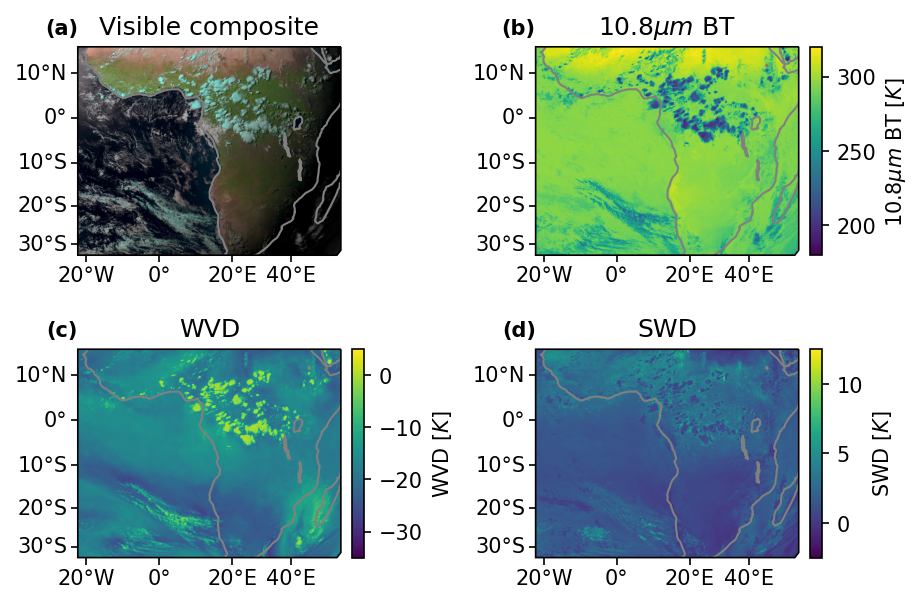

In [16]:
img_extent = (-19, 47, -33, 16)
fig = plt.figure(dpi=dpi)

cbar_size="4.5%"
cbar_pad=0.075
geo_p = ccrs.Geostationary(central_longitude=0.0, satellite_height=35785831, false_easting=0, false_northing=0, globe=None)
geo_extent = ( geo_p.x_limits[0], geo_p.x_limits[1], geo_p.y_limits[0], geo_p.y_limits[1] )
print(geo_extent)
# geo_extent = (-5500000, 5500000, -5500000, 5500000)

ax1 = plt.subplot(221, projection=geo_p)
ax1.imshow(_contrast_correction(rgb_IR[1], 100)[44:3667, 51:3660], extent=geo_extent)
ax1.set_extent(img_extent, crs=ccrs.PlateCarree())
ax1.coastlines(color="grey")
ax1.add_feature(cfeature.LAKES, edgecolor='grey', alpha=1, facecolor="none")
gl = ax1.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax_divider = make_axes_locatable(ax1)
cax_r = ax_divider.new_horizontal(size=cbar_size, pad=cbar_pad, axes_class=plt.Axes)
# fig.add_axes(cax_r)
ax1.set_title("(a)", loc="left", ha="right", weight="bold", fontsize=10)
ax1.set_title("Visible composite")


ax2 = plt.subplot(222, projection=geo_p)
bt_img = ax2.imshow(bt[1][44:3667, 51:3660], vmin=180, vmax=320, extent=geo_extent)
ax2.set_extent(img_extent, crs=ccrs.PlateCarree())
ax2.coastlines(color="grey")
ax2.add_feature(cfeature.LAKES, edgecolor='grey', alpha=1, facecolor="none")
gl = ax2.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax_divider = make_axes_locatable(ax2)
cax_r = ax_divider.new_horizontal(size=cbar_size, pad=cbar_pad, axes_class=plt.Axes)
fig.add_axes(cax_r)
plt.colorbar(bt_img, cax=cax_r, label="10.8$\mu m$ BT [$K$]")
ax2.set_title("(b)", loc="left", ha="right", weight="bold", fontsize=10)
ax2.set_title("10.8$\mu m$ BT")

ax3 = plt.subplot(223, projection=geo_p)
wvd_img = ax3.imshow(wvd[1][44:3667, 51:3660], vmin=-35, vmax=5, extent=geo_extent)
ax3.set_extent(img_extent, crs=ccrs.PlateCarree())
ax3.coastlines(color="grey")
ax3.add_feature(cfeature.LAKES, edgecolor='grey', alpha=1, facecolor="none")
gl = ax3.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax_divider = make_axes_locatable(ax3)
cax_r = ax_divider.new_horizontal(size=cbar_size, pad=cbar_pad, axes_class=plt.Axes)
fig.add_axes(cax_r)
plt.colorbar(wvd_img, cax=cax_r, label="WVD [$K$]")
ax3.set_title("(c)", loc="left", ha="right", weight="bold", fontsize=10)
ax3.set_title("WVD")

ax4 = plt.subplot(224, projection=geo_p)
swd_img = ax4.imshow(swd[1][44:3667, 51:3660], vmin=-2.5, vmax=12.5, extent=geo_extent)
ax4.set_extent(img_extent, crs=ccrs.PlateCarree())
ax4.coastlines(color="grey")
ax4.add_feature(cfeature.LAKES, edgecolor='grey', alpha=1, facecolor="none")
gl = ax4.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax_divider = make_axes_locatable(ax4)
cax_r = ax_divider.new_horizontal(size=cbar_size, pad=cbar_pad, axes_class=plt.Axes)
fig.add_axes(cax_r)
plt.colorbar(swd_img, cax=cax_r, label="SWD [$K$]")
ax4.set_title("(d)", loc="left", ha="right", weight="bold", fontsize=10)
ax4.set_title("SWD")

plt.subplots_adjust(hspace=0.2, wspace=0.6)

plt.draw()
add_gl_ticks(ax1, gl)
add_gl_ticks(ax2, gl)
add_gl_ticks(ax3, gl)
add_gl_ticks(ax4, gl)

figure_list.append(plt.gcf())

# Figure 2: Example broadband fluxes

In [17]:
flx_ds = xr.open_dataset(data_path / "broadband_flux_data.nc")

In [18]:
flx_ds

<xarray.Dataset>
Dimensions:       (along_track: 1601, across_track: 2081)
Dimensions without coordinates: along_track, across_track
Data variables: (12/37)
    time          (along_track, across_track) datetime64[ns] ...
    lat           (along_track, across_track) float32 ...
    lon           (along_track, across_track) float32 ...
    retrflag      (along_track, across_track) float32 ...
    toa_swdn      (along_track, across_track) float32 ...
    toa_swup      (along_track, across_track) float32 ...
    ...            ...
    boa_lwdn_cre  (along_track, across_track) float32 ...
    boa_lwup_cre  (along_track, across_track) float32 ...
    toa_net       (along_track, across_track) float32 ...
    toa_net_cre   (along_track, across_track) float32 ...
    boa_net       (along_track, across_track) float32 ...
    boa_net_cre   (along_track, across_track) float32 ...
Attributes: (12/36)
    Conventions:            CF-1.6,ACDD-1.3
    title:                  ESA Cloud CCI Retrieval Products L2 Primary File
    institution:            Deutscher Wetterdienst
    source:                 null
    history:                Dataset produced by DWDs CC4CL retrieval system i...
    references:             https://climate.esa.int/en/projects/cloud/
    ...                     ...
    Emissivity_File:        /scratch/ms/de/sf7/esa_cci_c_proc/CCFLOW_SEV_DEV/...
    USGS_File:              /scratch/ms/de/sf7/esa_cci_c_proc/CCFLOW_SEV_DEV/...
    Snow_File:              /scratch/ms/de/sf7/esa_cci_c_proc/CCFLOW_SEV_DEV/...
    Sea_Ice_File:           /scratch/ms/de/sf7/esa_cci_c_proc/CCFLOW_SEV_DEV/...
    Level1b_File:           /scratch/ms/de/sf7/esa_cci_c_proc/CCFLOW_SEV_DEV/...
    Geo_File:               /scratch/ms/de/sf7/esa_cci_c_proc/CCFLOW_SEV_DEV/...

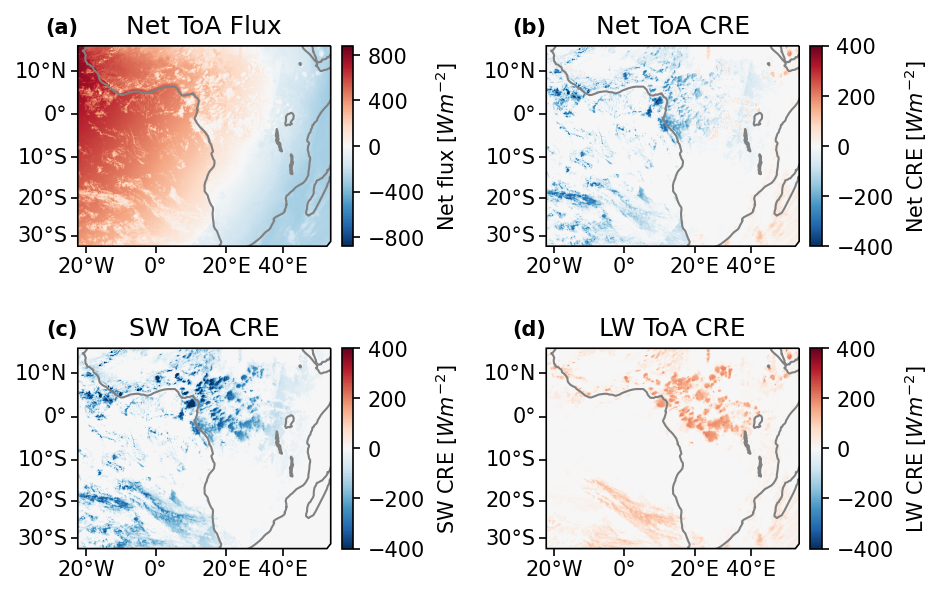

In [19]:
from matplotlib import colors

img_extent = (-19, 47, -33, 16)
fig = plt.figure(dpi=dpi)

cbar_size="4.5%"
cbar_pad=0.075

ax1 = plt.subplot(221, projection=ccrs.Geostationary())
# ax1.imshow(_contrast_correction(rgb_IR[1], 100)[44:3667, 51:3660], extent=geo_extent)
ax1.set_extent(img_extent, crs=ccrs.PlateCarree())
norm = colors.CenteredNorm(halfrange=800)
norm.vmin=-400
norm.vmax=800
norm._changed()
norm = colors.CenteredNorm()
net_flux_img = ax1.imshow(flx_ds.toa_net[::-1,::-1], cmap="RdBu_r", norm=norm, extent=ax1.get_extent())
ax1.coastlines(color="grey")
ax1.add_feature(cfeature.LAKES, edgecolor='grey', alpha=1, facecolor="none")
gl = ax1.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax_divider = make_axes_locatable(ax1)
cax_r = ax_divider.new_horizontal(size=cbar_size, pad=cbar_pad, axes_class=plt.Axes)
fig.add_axes(cax_r)
cbar = plt.colorbar(net_flux_img, cax=cax_r, label="Net flux [$Wm^{-2}$]")
cbar.ax.set_yticks([-800,-400,0,400,800])
ax1.set_title("(a)", loc="left", ha="right", weight="bold", fontsize=10)
ax1.set_title("Net ToA Flux")


ax2 = plt.subplot(222, projection=ccrs.Geostationary())
ax2.set_extent(img_extent, crs=ccrs.PlateCarree())
net_cre_img = ax2.imshow(flx_ds.toa_net_cre[::-1,::-1], cmap="RdBu_r", vmin=-400, vmax=400, extent=ax2.get_extent())
ax2.coastlines(color="grey")
ax2.add_feature(cfeature.LAKES, edgecolor='grey', alpha=1, facecolor="none")
gl = ax2.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax_divider = make_axes_locatable(ax2)
cax_r = ax_divider.new_horizontal(size=cbar_size, pad=cbar_pad, axes_class=plt.Axes)
fig.add_axes(cax_r)
plt.colorbar(net_cre_img, cax=cax_r, label="Net CRE [$Wm^{-2}$]")
ax2.set_title("(b)", loc="left", ha="right", weight="bold", fontsize=10)
ax2.set_title("Net ToA CRE")

ax3 = plt.subplot(223, projection=ccrs.Geostationary())
ax3.set_extent(img_extent, crs=ccrs.PlateCarree())
norm = colors.CenteredNorm(halfrange=400)
norm.vmax=0
sw_cre_img = ax3.imshow(
    -flx_ds.toa_swup_cre[::-1,::-1], cmap="RdBu_r", vmin=-400, vmax=400, extent=ax3.get_extent()
)
ax3.coastlines(color="grey")
ax3.add_feature(cfeature.LAKES, edgecolor='grey', alpha=1, facecolor="none")
gl = ax3.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax_divider = make_axes_locatable(ax3)
cax_r = ax_divider.new_horizontal(size=cbar_size, pad=cbar_pad, axes_class=plt.Axes)
fig.add_axes(cax_r)
plt.colorbar(sw_cre_img, cax=cax_r, label="SW CRE [$Wm^{-2}$]")
ax3.set_title("(c)", loc="left", ha="right", weight="bold", fontsize=10)
ax3.set_title("SW ToA CRE")

ax4 = plt.subplot(224, projection=ccrs.Geostationary())
ax4.set_extent(img_extent, crs=ccrs.PlateCarree())
norm = colors.CenteredNorm(halfrange=400)
norm.vmin=0
lw_cre_img = ax4.imshow(
    -flx_ds.toa_lwup_cre[::-1,::-1], cmap="RdBu_r", vmin=-400, vmax=400, extent=ax4.get_extent()
)
ax4.coastlines(color="grey")
ax4.add_feature(cfeature.LAKES, edgecolor='grey', alpha=1, facecolor="none")
gl = ax4.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax_divider = make_axes_locatable(ax4)
cax_r = ax_divider.new_horizontal(size=cbar_size, pad=cbar_pad, axes_class=plt.Axes)
fig.add_axes(cax_r)
plt.colorbar(lw_cre_img, cax=cax_r, label="LW CRE [$Wm^{-2}$]")
ax4.set_title("(d)", loc="left", ha="right", weight="bold", fontsize=10)
ax4.set_title("LW ToA CRE")

plt.subplots_adjust(hspace=0.2, wspace=0.7)

def add_gl_ticks(ax, gl):
    x_tick_locs = []
    if gl.bottom_labels:
        x_tick_locs += [
            artist.properties()["unitless_position"][0]
            for artist in gl.bottom_label_artists
            if artist.properties()["visible"]
        ]
    if gl.top_labels:
        x_tick_locs += [
            artist.properties()["unitless_position"][0]
            for artist in gl.top_label_artists
            if artist.properties()["visible"]
        ]
    x_tick_labels = [""] * len(x_tick_locs)
    ax.set_xticks(x_tick_locs, crs=ax.projection)
    ax.set_xticklabels(x_tick_labels)

    y_tick_locs = []
    if gl.left_labels:
        y_tick_locs += [
            artist.properties()["unitless_position"][1]
            for artist in gl.left_label_artists
            if artist.properties()["visible"]
        ]
    if gl.right_labels:
        y_tick_locs += [
            artist.properties()["unitless_position"][1]
            for artist in gl.right_label_artists
            if artist.properties()["visible"]
        ]
    y_tick_labels = [""] * len(y_tick_locs)
    ax.set_yticks(y_tick_locs, crs=ax.projection)
    ax.set_yticklabels(y_tick_labels)

    ax.tick_params(
        top=gl.top_labels,
        bottom=gl.bottom_labels,
        left=gl.left_labels,
        right=gl.right_labels,
    )

plt.draw()
add_gl_ticks(ax1, gl)
add_gl_ticks(ax2, gl)
add_gl_ticks(ax3, gl)
add_gl_ticks(ax4, gl)

figure_list.append(plt.gcf())

# Figure 3: Calibration of broadband fluxes

In [20]:
thick_anvil_step_lat = np.concatenate([ds.thick_anvil_step_lat.data for ds in datasets])
thick_anvil_step_lon = np.concatenate([ds.thick_anvil_step_lon.data for ds in datasets])
thick_anvil_step_valid = np.concatenate(
    [np.isin(ds.thick_anvil_step_anvil_index, ds.anvil[np.logical_and(ds.thick_anvil_is_valid, ds.thick_anvil_start_lat>-15)]) for ds in datasets]
)

# CERES Fluxes
calibration_flx_ds = xr.load_dataset(data_path / "calibration_data.nc")

In [21]:
calibration_flx_ds

<xarray.Dataset>
Dimensions:             (lat: 49, lon: 66, month: 4)
Coordinates:
  * lat                 (lat) float64 -32.5 -31.5 -30.5 -29.5 ... 13.5 14.5 15.5
  * lon                 (lon) float64 -18.5 -17.5 -16.5 -15.5 ... 44.5 45.5 46.5
  * month               (month) int64 5 6 7 8
Data variables:
    ceres_toa_net_cre   (month, lat, lon) float32 -5.335 -5.331 ... 15.41 13.52
    ceres_toa_sw_cre    (month, lat, lon) float32 -39.18 -38.1 ... -10.79 -10.17
    ceres_toa_lw_cre    (month, lat, lon) float32 33.85 32.77 ... 26.2 23.69
    seviri_toa_net_cre  (month, lat, lon) float64 nan nan nan ... 8.361 13.23
    seviri_toa_sw_cre   (month, lat, lon) float64 nan nan nan ... 23.02 12.18
    seviri_toa_lw_cre   (month, lat, lon) float64 nan nan nan ... -31.38 -25.41

In [22]:
# Function for plotting and comparing bias between two datasets
def bias_plot(ax4, obs, truths, weights):
    from scipy.stats import linregress
    from sklearn.linear_model import LinearRegression
    from tobac_flow.utils import weighted_average_and_std
    
    def cov(x, y, w):
        """Weighted Covariance"""
        return np.sum(w * (x - np.average(x, weights=w)) * (y - np.average(y, weights=w))) / np.sum(w)

    def corr(x, y, w):
        """Weighted Correlation"""
        return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))
    
    # Plot points
    ax4.scatter(truths.ravel(), obs.ravel(), alpha=0.05, c="b")
    # 1-1 line
    ax4.plot([-1e4,1e4],[-1e4,1e4], "k--")
    
    # Find linear fit and plot
    wh = np.isfinite(obs.ravel())
    linear_fit = linregress(truths.ravel()[wh], obs.ravel()[wh])
    print(f'All points -- Slope: {linear_fit.slope}, Intercept:{linear_fit.intercept}')
    fit_equation = lambda x : linear_fit.slope * x + linear_fit.intercept
    plt.plot(np.array([-1e4,1e4]), fit_equation(np.array([-1e4,1e4])), "b")

    # Get info about fit/bias
    wh = np.isfinite(obs)
    bias = (obs[wh] - truths[wh]).mean()
    std = (obs[wh] - truths[wh]).std()
    std *= (wh.sum() / (wh.sum() - 1))
    rmse = ((obs[wh] - truths[wh])**2).mean()**0.5
    r_value = np.corrcoef(truths[wh], obs[wh])[0,1]
    n_points = wh.sum()
    units = "$Wm^{-2}$"
    print(f'Bias: {bias:.02f} {units}')
    print(f'Std: {std:.02f} {units}')
    print(f'RMSE: {rmse:.02f} {units}')
    print(f'R: {r_value:.02f}')
    print(f'N: {n_points}')
    ax4.text(0.975, 0.025, 
        f'All locations:\nBias: {bias:.02f} {units}\nStd: {std:.02f} {units}\nRMSE: {rmse:.02f} {units}\nR: {r_value:.02f}\nN: {n_points}',
        color="b", ha="right", va="bottom", transform=ax4.transAxes
    )

    # Now weight by DCC anvil locations
    wh = weights > 0
    ax4.scatter(truths[wh], obs[wh], alpha=0.05, c="r")

    regr = LinearRegression()
    regr.fit(truths[wh].reshape(-1, 1), obs[wh].reshape(-1, 1), weights[wh])
    print(f'DCC weighted -- Slope: {regr.coef_[0][0]}, Intercept:{regr.intercept_[0]}')
    plt.plot(np.array([-1e4,1e4]), regr.predict(np.array([-1e4,1e4]).reshape(-1, 1)), "r")

    wh = weights > 0
    weighted_bias, weighted_std = weighted_average_and_std((obs - truths)[wh], weights = weights[wh])
    weighted_rmse = np.average((obs - truths)[wh]**2, weights=weights[wh])**0.5
    weighted_r = corr(truths[wh],obs[wh],weights[wh])
    weighted_n = wh.sum()
    units = "$Wm^{-2}$"
    print(f'Bias: {weighted_bias:.02f} {units}')
    print(f'Std: {weighted_std:.02f} {units}')
    print(f'RMSE: {weighted_rmse:.02f} {units}')
    print(f'R: {weighted_r:.02f}')
    print(f'N: {weighted_n}')
    ax4.text(0.025, 0.975, 
        f'DCC observation weighted:\nBias: {weighted_bias:.02f} {units}\nStd: {weighted_std:.02f} {units}\nRMSE: {weighted_rmse:.02f} {units}\nR: {weighted_r:.02f}\nN: {weighted_n}',
        color="r", ha="left", va="top", transform=ax4.transAxes
    )


All points -- Slope: 1.1246973356629042, Intercept:-3.222555247435544
Bias: -5.05 $Wm^{-2}$
Std: 9.05 $Wm^{-2}$
RMSE: 10.36 $Wm^{-2}$
R: 0.92
N: 12556
DCC weighted -- Slope: 1.027320384979248, Intercept:-1.438467025756836
Bias: -1.87 $Wm^{-2}$
Std: 9.45 $Wm^{-2}$
RMSE: 9.63 $Wm^{-2}$
R: 0.93
N: 5812
All points -- Slope: 1.0297973917550125, Intercept:-3.7510179105763015
Bias: -4.81 $Wm^{-2}$
Std: 8.48 $Wm^{-2}$
RMSE: 9.75 $Wm^{-2}$
R: 0.95
N: 12556
DCC weighted -- Slope: 0.9834634065628052, Intercept:-3.01605224609375
Bias: -2.02 $Wm^{-2}$
Std: 8.64 $Wm^{-2}$
RMSE: 8.87 $Wm^{-2}$
R: 0.94
N: 5812
All points -- Slope: 0.9750314351235921, Intercept:0.2778181031048952
Bias: -0.24 $Wm^{-2}$
Std: 3.68 $Wm^{-2}$
RMSE: 3.69 $Wm^{-2}$
R: 0.98
N: 12556
DCC weighted -- Slope: 0.9116714596748352, Intercept:4.097908020019531
Bias: 0.15 $Wm^{-2}$
Std: 5.29 $Wm^{-2}$
RMSE: 5.29 $Wm^{-2}$
R: 0.93
N: 5812


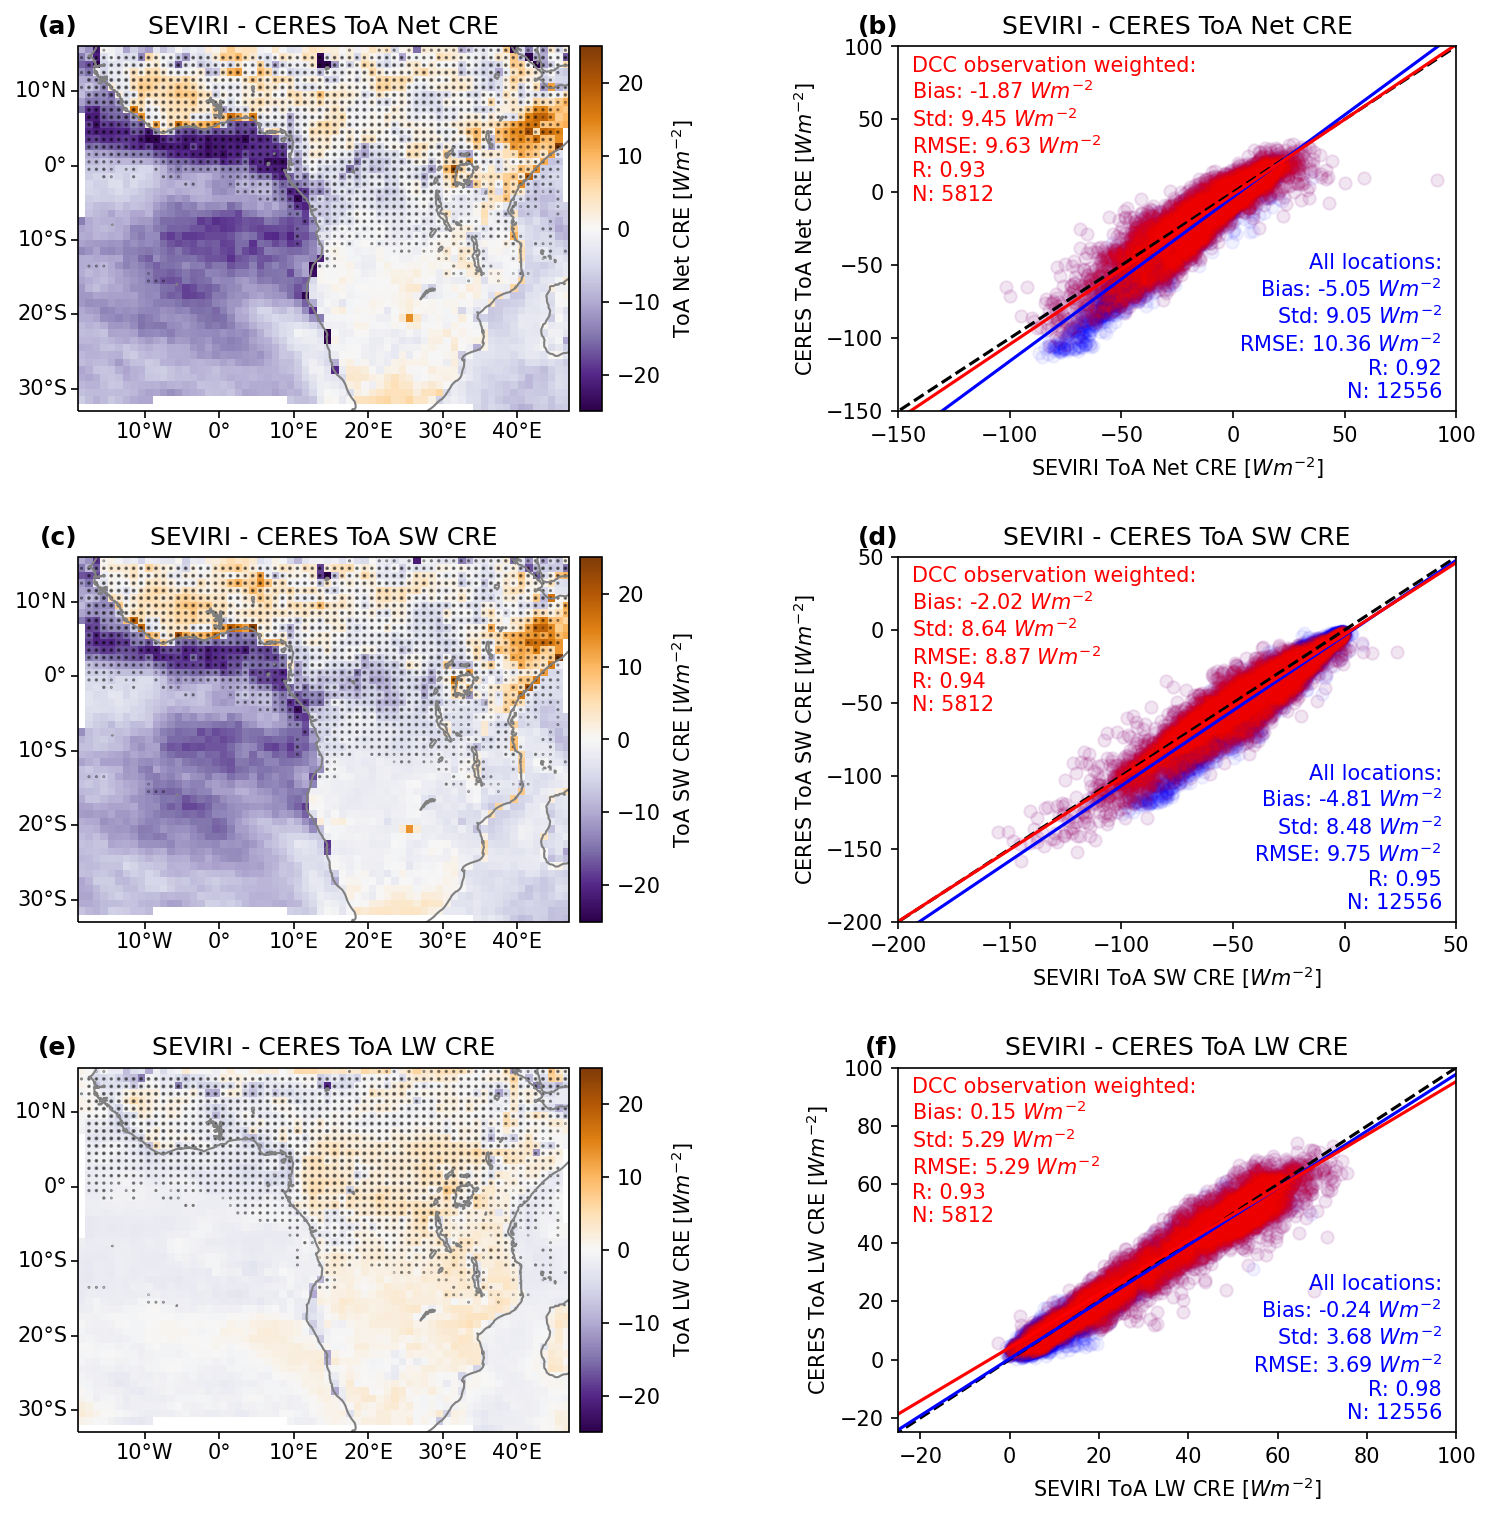

In [23]:
fig = plt.figure(dpi=dpi, figsize=(12,12))

img_extent = (-19, 47, -33, 16)
lons = slice(img_extent[0], img_extent[1])
lats = slice(img_extent[2], img_extent[3])
cbar_size="4.5%"
cbar_pad=0.075

ax = plt.subplot(322)

obs = calibration_flx_ds.seviri_toa_net_cre.sel(lon=lons, lat=lats).to_numpy()
truths = calibration_flx_ds.ceres_toa_net_cre.sel(lon=lons, lat=lats).to_numpy()
weights = np.stack([
    np.histogram2d(
        thick_anvil_step_lat[thick_anvil_step_valid], thick_anvil_step_lon[thick_anvil_step_valid], 
        bins=[np.arange(img_extent[2],img_extent[3]+1), np.arange(img_extent[0],img_extent[1]+1)]
    )[0]
]*4, 0)

plt.xlim([-150,100])
plt.ylim([-150,100])
bias_plot(ax, obs, truths, weights)
ax.set_title("(b)", loc="left", ha="right", weight="bold")
ax.set_title("SEVIRI - CERES ToA Net CRE", fontsize=12)
ax.set_xlabel("SEVIRI ToA Net CRE [$Wm^{-2}$]")
ax.set_ylabel("CERES ToA Net CRE [$Wm^{-2}$]")

ax = plt.subplot(324)
obs = -calibration_flx_ds.seviri_toa_sw_cre.sel(lon=lons, lat=lats).to_numpy()
truths = calibration_flx_ds.ceres_toa_sw_cre.sel(lon=lons, lat=lats).to_numpy()
bias_plot(ax, obs, truths, weights)
plt.xlim([-200,50])
plt.ylim([-200,50])
ax.set_title("(d)", loc="left", ha="right", weight="bold")
ax.set_title("SEVIRI - CERES ToA SW CRE", fontsize=12)
ax.set_xlabel("SEVIRI ToA SW CRE [$Wm^{-2}$]")
ax.set_ylabel("CERES ToA SW CRE [$Wm^{-2}$]")

ax = plt.subplot(326)
obs = -calibration_flx_ds.seviri_toa_lw_cre.sel(lon=lons, lat=lats).to_numpy()
truths = calibration_flx_ds.ceres_toa_lw_cre.sel(lon=lons, lat=lats).to_numpy()
bias_plot(ax, obs, truths, weights)
plt.xlim([-25,100])
plt.ylim([-25,100])
ax.set_title("(f)", loc="left", ha="right", weight="bold")
ax.set_title("SEVIRI - CERES ToA LW CRE", fontsize=12)
ax.set_xlabel("SEVIRI ToA LW CRE [$Wm^{-2}$]")
ax.set_ylabel("CERES ToA LW CRE [$Wm^{-2}$]")

ax3 = plt.subplot(321, projection=ccrs.PlateCarree())
obs = calibration_flx_ds.seviri_toa_net_cre.sel(lon=lons, lat=lats)
truths = calibration_flx_ds.ceres_toa_net_cre.sel(lon=lons, lat=lats)
img = ax3.imshow(
    (obs.mean("month") - truths.mean("month")).sel(lon=lons, lat=lats), 
    cmap="PuOr_r", vmin=-25, vmax=25, extent=img_extent, origin="lower"
)
counts = np.histogram2d(
    thick_anvil_step_lat[thick_anvil_step_valid], thick_anvil_step_lon[thick_anvil_step_valid], 
    bins=[np.arange(img_extent[2],img_extent[3]+1), np.arange(img_extent[0],img_extent[1]+1)]
)[0]
wh = counts > 0
lon_grid, lat_grid = np.meshgrid(
    np.arange(img_extent[0]+0.5, img_extent[1]), np.arange(img_extent[2]+0.5, img_extent[3])
)
sizes = ((np.log10(counts[wh])+1)*0.25)**2
ax3.scatter(lon_grid[wh], lat_grid[wh], c="k", s=sizes, alpha=0.5)
ax3.coastlines(color="grey")
ax3.add_feature(cfeature.LAKES, edgecolor='grey', alpha=1, facecolor="none")
gl = ax3.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax_divider = make_axes_locatable(ax3)
cax_r = ax_divider.new_horizontal(size=cbar_size, pad=cbar_pad, axes_class=plt.Axes)
fig.add_axes(cax_r)
plt.colorbar(img, cax=cax_r, label="ToA Net CRE [$Wm^{-2}$]")

ax3.set_title("(a)", loc="left", ha="right", weight="bold")
ax3.set_title("SEVIRI - CERES ToA Net CRE", fontsize=12)

ax1 = ax3

ax3 = plt.subplot(323, projection=ccrs.PlateCarree())
obs = -calibration_flx_ds.seviri_toa_sw_cre.sel(lon=lons, lat=lats)
truths = calibration_flx_ds.ceres_toa_sw_cre.sel(lon=lons, lat=lats)

img = ax3.imshow(
    (obs.mean("month") - truths.mean("month")).sel(lon=lons, lat=lats),
    cmap="PuOr_r", vmin=-25, vmax=25, extent=img_extent, origin="lower"
)
ax3.scatter(lon_grid[wh], lat_grid[wh], c="k", s=sizes, alpha=0.5)
ax3.coastlines(color="grey")
ax3.add_feature(cfeature.LAKES, edgecolor='grey', alpha=1, facecolor="none")
gl = ax3.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax_divider = make_axes_locatable(ax3)
cax_r = ax_divider.new_horizontal(size=cbar_size, pad=cbar_pad, axes_class=plt.Axes)
fig.add_axes(cax_r)
plt.colorbar(img, cax=cax_r, label="ToA SW CRE [$Wm^{-2}$]")

ax3.set_title("(c)", loc="left", ha="right", weight="bold")
ax3.set_title("SEVIRI - CERES ToA SW CRE", fontsize=12)

ax2 = ax3

ax3 = plt.subplot(325, projection=ccrs.PlateCarree())
obs = -calibration_flx_ds.seviri_toa_lw_cre.sel(lon=lons, lat=lats)
truths = calibration_flx_ds.ceres_toa_lw_cre.sel(lon=lons, lat=lats)
img = ax3.imshow(
    (obs.mean("month") - truths.mean("month")).sel(lon=lons, lat=lats),
    cmap="PuOr_r", vmin=-25, vmax=25, extent=img_extent, origin="lower"
)
ax3.scatter(lon_grid[wh], lat_grid[wh], c="k", s=sizes, alpha=0.5)
ax3.coastlines(color="grey")
ax3.add_feature(cfeature.LAKES, edgecolor='grey', alpha=1, facecolor="none")
gl = ax3.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax_divider = make_axes_locatable(ax3)
cax_r = ax_divider.new_horizontal(size=cbar_size, pad=cbar_pad, axes_class=plt.Axes)
fig.add_axes(cax_r)
plt.colorbar(img, cax=cax_r, label="ToA LW CRE [$Wm^{-2}$]")

ax3.set_title("(e)", loc="left", ha="right", weight="bold")
ax3.set_title("SEVIRI - CERES ToA LW CRE", fontsize=12)

plt.subplots_adjust(hspace=0.4, wspace=0.5)

plt.draw()
add_gl_ticks(ax1, gl)
add_gl_ticks(ax2, gl)
add_gl_ticks(ax3, gl)

figure_list.append(plt.gcf())

In [24]:
net_bias = 1.87
sw_bias = 2.02
lw_bias = -0.15

## Supplementary figure 1: Expected sensitivity of SEVIRI to anvil clouds

In [25]:
from pyspectral import blackbody
from pyspectral.rsr_reader import RelativeSpectralResponse
bt_ds = xr.load_dataset(data_path / "pyLRT_anvil_data.nc")

rsr data may not be up to date: /Users/jonesw/Library/Application Support/pyspectral/rsr_seviri_Meteosat-11.h5
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 71.45kB/s]


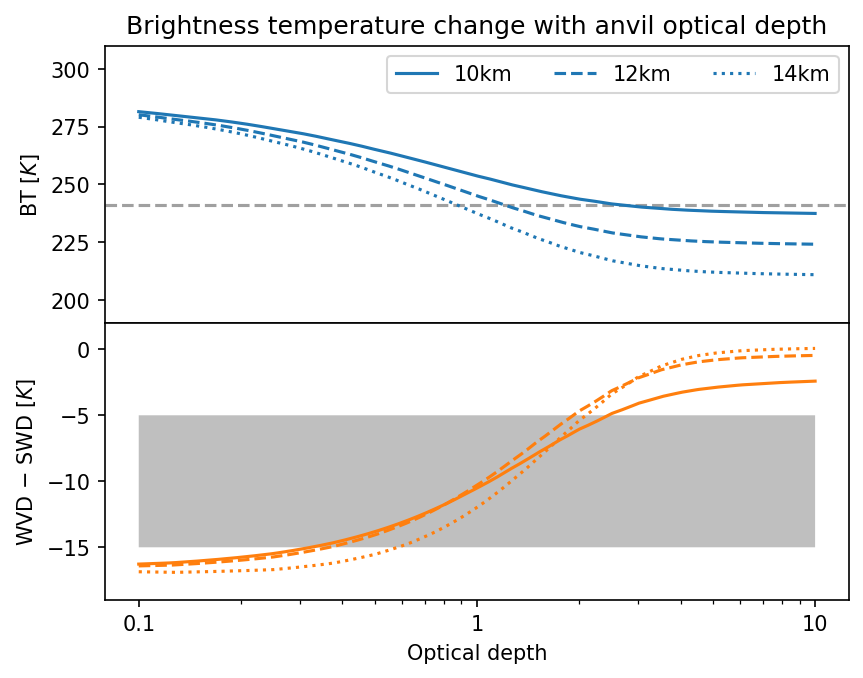

In [26]:
from scipy import interpolate
fig, axs = plt.subplots(2, 1, sharex=True, dpi=dpi)
# Remove vertical space between axes
fig.subplots_adjust(hspace=0)

xlocs = np.linspace(np.log(0.1), np.log(10), 1000)
xvals = np.minimum(np.exp(xlocs), 10)

seviri_rsr = RelativeSpectralResponse("Meteosat-11", "seviri")

linestyles = ["-", "--", ":"]
for h, height in enumerate(bt_ds.height):
    bt_funcs = [interpolate.interp1d(bt_ds.wavelength.data, bt_ds.clear_sky_bt.data)]
    
    for i in range(bt_ds.optical_depth.size):
        bt_funcs.append(interpolate.interp1d(
            bt_ds.wavelength.data, bt_ds.anvil_bt.sel(height=height)[i]
        ))

    bt_by_channel = {}
    for band in ['IR8.7', 'IR7.3', 'IR13.4', 'IR6.2', 'IR12.0', 'IR10.8', 'IR9.7', 'IR3.9']:
        rsr = seviri_rsr.rsr[band]["det-1"]
        wavelengths = rsr["wavelength"]/1e6
        wh = np.logical_and(wavelengths > 3e-6, wavelengths < 15e-6)
        srf = rsr["response"]
        bt_by_channel[band] = [np.average(bt(wavelengths[wh]), weights=srf[wh]) for bt in bt_funcs]

    bt_od_func = {band:interpolate.interp1d(
        [0]+bt_ds.optical_depth.values.tolist(), bt_by_channel[band]
    ) for band in ['IR6.2','IR7.3','IR10.8','IR12.0']}
    
    wvd_od = bt_od_func['IR6.2'](xvals) - bt_od_func["IR7.3"](xvals)
    swd_od = bt_od_func["IR10.8"](xvals) - bt_od_func["IR12.0"](xvals)
    axs[0].plot(xlocs, bt_od_func["IR10.8"](xvals), linestyle=linestyles[h], c="C00")
    axs[1].plot(xlocs, wvd_od - swd_od, linestyle=linestyles[h], c="C01")
    
# Plot each graph, and manually set the y tick values
axs[0].set_ylabel("BT [$K$]")
axs[0].legend(["10km", "12km", "14km"], ncol=3)
axs[0].set_ylim([190,310])
axs[0].set_yticks(range(200,301,25))
axs[0].axhline(241, color="grey", ls="--", alpha=0.75, zorder=0)

axs[1].set_ylabel("WVD $-$ SWD [$K$]")
axs[1].set_yticks(range(-15,1,5))
axs[1].set_ylim([-19,2])
axs[1].fill_between(xlocs, -5, -15, color="grey", alpha=0.5, edgecolor="none")


axs[0].set_title("Brightness temperature change with anvil optical depth")
plt.xticks([np.log(0.1), np.log(1), np.log(10)], [0.1, 1, 10])
plt.xticks(np.log(np.arange(0.1,1,0.1)).tolist() + np.log(np.arange(1,11,1)).tolist(), minor=True)
plt.xlabel("Optical depth")

figure_list.append(plt.gcf())

## Supplementary figure 2: Difference in window IR channels between GOES and SEVIRI

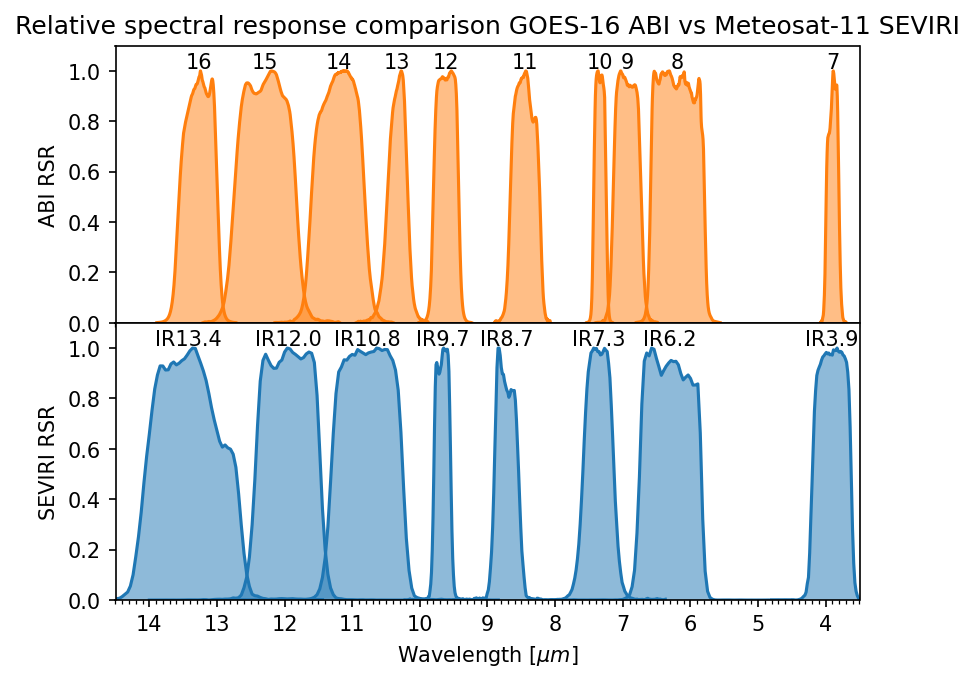

In [27]:
fig, axs = plt.subplots(2, 1, sharex=True, dpi=dpi, figsize=(6.4,4.8))
# Remove vertical space between axes
fig.subplots_adjust(hspace=0)

(ax1, ax2) = axs


ax2.set_xticks((np.arange(3000,15001,1000)), np.arange(3,16))
ax2.xaxis.set_ticks(np.arange(3000,15001,100), minor=True)
ax2.set_xlim((14500), (3500))
ax2.set_xlabel("Wavelength [$\mu m$]")

abi_rsr = RelativeSpectralResponse('GOES-16', 'abi')

for band in ['ch7','ch8','ch9','ch10','ch11','ch12','ch13','ch14','ch15','ch16']:
    rsr = abi_rsr.rsr[band]["det-1"]
    ax1.plot((rsr["wavelength"]*1e3), rsr["response"], "C1")
    ax1.fill_between((rsr["wavelength"]*1e3), rsr["response"], facecolor="C1", alpha=0.5)
    ax1.text((rsr["central_wavelength"]*1e3), 1.01, band[2:], ha="center")

seviri_rsr = RelativeSpectralResponse('Meteosat-11', 'seviri')

for band in ['IR8.7', 'IR7.3', 'IR13.4', 'IR6.2', 'IR12.0', 'IR10.8', 'IR9.7', 'IR3.9']:
    rsr = seviri_rsr.rsr[band]["det-1"]
    plt.plot((rsr["wavelength"]*1e3), rsr["response"], "C0")
    plt.fill_between((rsr["wavelength"]*1e3), rsr["response"], facecolor="C0", alpha=0.5)
    plt.text((rsr["central_wavelength"]*1e3), 1.01, band, ha="center")

ax1.set_ylim([0,1.1])
ax1.set_ylabel("ABI RSR")

ax2.set_ylim([0,1.1])
ax2.set_ylabel("SEVIRI RSR")

ax1.set_title("Relative spectral response comparison GOES-16 ABI vs Meteosat-11 SEVIRI")

figure_list.append(plt.gcf())

## Supplementary figure 3: Comparison of GOES and SEVIRI sensitivty to thin anvil

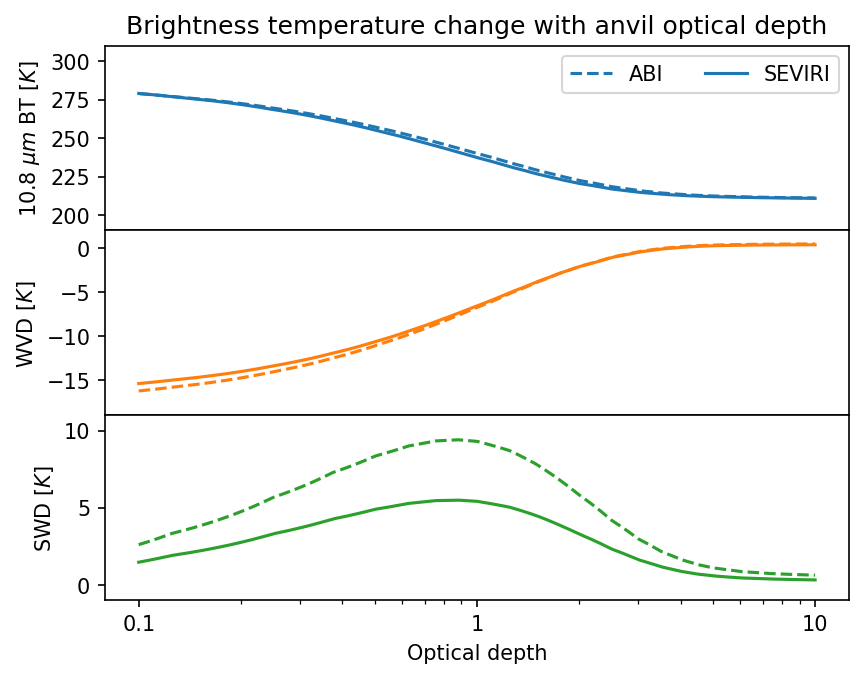

In [28]:
fig, axs = plt.subplots(3, 1, sharex=True, dpi=dpi)
# Remove vertical space between axes
fig.subplots_adjust(hspace=0)

xlocs = np.linspace(np.log(0.1), np.log(10), 1000)
xvals = np.minimum(np.exp(xlocs), 10)

abi_rsr = RelativeSpectralResponse('GOES-16', 'abi')

linestyles = ["--", "-", ":"]
for h, height in enumerate(bt_ds.height[-1:]):
    bt_funcs = [interpolate.interp1d(bt_ds.wavelength.data, bt_ds.clear_sky_bt.data)]
    
    for i in range(bt_ds.optical_depth.size):
        bt_funcs.append(interpolate.interp1d(
            bt_ds.wavelength.data, bt_ds.anvil_bt.sel(height=height)[i]
        ))

    bt_by_channel = {}
    for band in ['ch7','ch8','ch9','ch10','ch11','ch12','ch13','ch14','ch15','ch16']:
        rsr = abi_rsr.rsr[band]["det-1"]
        wavelengths = rsr["wavelength"]/1e6
        srf = rsr["response"]
        bt_by_channel[band] = [np.average(bt(wavelengths), weights=srf) for bt in bt_funcs]

    bt_od_func = {band:interpolate.interp1d(
        [0]+bt_ds.optical_depth.values.tolist(), bt_by_channel[band]
    ) for band in ['ch8','ch10','ch13','ch15']}
    
    wvd_od = bt_od_func["ch8"](xvals) - bt_od_func["ch10"](xvals)
    swd_od = bt_od_func["ch13"](xvals) - bt_od_func["ch15"](xvals)
    abi_line = axs[0].plot(xlocs, bt_od_func["ch13"](xvals), linestyle=linestyles[h], c="C00")
    axs[1].plot(xlocs, wvd_od, linestyle=linestyles[h], c="C01")
    axs[2].plot(xlocs, swd_od, linestyle=linestyles[h], c="C02")

linestyles = ["-", ":"]
for h, height in enumerate(bt_ds.height[-1:]):
    bt_funcs = [interpolate.interp1d(bt_ds.wavelength.data, bt_ds.clear_sky_bt.data)]
    
    for i in range(bt_ds.optical_depth.size):
        bt_funcs.append(interpolate.interp1d(
            bt_ds.wavelength.data, bt_ds.anvil_bt.sel(height=height)[i]
        ))

    bt_by_channel = {}
    for band in ['IR8.7', 'IR7.3', 'IR13.4', 'IR6.2', 'IR12.0', 'IR10.8', 'IR9.7', 'IR3.9']:
        rsr = seviri_rsr.rsr[band]["det-1"]
        wavelengths = rsr["wavelength"]/1e6
        wh = np.logical_and(wavelengths > 3e-6, wavelengths < 15e-6)
        srf = rsr["response"]
        bt_by_channel[band] = [np.average(bt(wavelengths[wh]), weights=srf[wh]) for bt in bt_funcs]

    bt_od_func = {band:interpolate.interp1d(
        [0]+bt_ds.optical_depth.values.tolist(), bt_by_channel[band]
    ) for band in ['IR6.2','IR7.3','IR10.8','IR12.0']}
    
    wvd_od = bt_od_func['IR6.2'](xvals) - bt_od_func["IR7.3"](xvals)
    swd_od = bt_od_func["IR10.8"](xvals) - bt_od_func["IR12.0"](xvals)
    sev_line = axs[0].plot(xlocs, bt_od_func["IR10.8"](xvals), linestyle=linestyles[h], c="C00")
    axs[1].plot(xlocs, wvd_od, linestyle=linestyles[h], c="C01")
    axs[2].plot(xlocs, swd_od, linestyle=linestyles[h], c="C02")
    
# Plot each graph, and manually set the y tick values
axs[0].set_ylabel("10.8 $\mu m$ BT [$K$]")
axs[0].legend([abi_line[0], sev_line[0]], ["ABI", "SEVIRI"], ncol=2)
axs[0].set_ylim([190,310])
axs[0].set_yticks(range(200,301,25))

axs[1].set_ylabel("WVD [$K$]")
axs[1].set_yticks(range(-15,1,5))
axs[1].set_ylim([-19,2])
# axs[1].legend(["WVD"], loc="right")

axs[2].set_ylabel("SWD [$K$]")
axs[2].set_ylim([-1,11])
# axs[2].legend(["SWD"], loc="right")

axs[0].set_title("Brightness temperature change with anvil optical depth")
plt.xticks([np.log(0.1), np.log(1), np.log(10)], [0.1, 1, 10])
plt.xticks(np.log(np.arange(0.1,1,0.1)).tolist() + np.log(np.arange(1,11,1)).tolist(), minor=True)
plt.xlabel("Optical depth")

figure_list.append(plt.gcf())

## Figure 4: Example DCC detection

In [29]:
dcc_ds = xr.open_dataset(data_path / "example_dcc_labels.nc")

In [30]:
dcc_ds

<xarray.Dataset>
Dimensions:                                             (along_track: 1601,
                                                         across_track: 2081,
                                                         t: 96, y: 1601,
                                                         x: 2081, core: 1596,
                                                         anvil: 1164,
                                                         core_step: 8181,
                                                         thick_anvil_step: 10879,
                                                         thin_anvil_step: 11695,
                                                         lsflag: 2,
                                                         lusflag: 24, illum: 3,
                                                         cldtype: 10, phase: 2)
Coordinates: (12/13)
  * t                                                   (t) datetime64[ns] 20...
  * along_track                                         (along_track) int64 0...
  * across_track                                        (across_track) int64 ...
  * core                                                (core) int32 1 ... 1611
  * anvil                                               (anvil) int32 1 ... 1165
  * core_step                                           (core_step) int32 1 ....
    ...                                                  ...
  * thin_anvil_step                                     (thin_anvil_step) int32 ...
  * lsflag                                              (lsflag) int64 0 1
  * lusflag                                             (lusflag) int64 1 ... 24
  * illum                                               (illum) int64 1 2 3
  * cldtype                                             (cldtype) int64 0 ... 9
  * phase                                               (phase) int64 1 2
Dimensions without coordinates: y, x
Data variables: (12/557)
    lat                                                 (along_track, across_track) float32 ...
    lon                                                 (along_track, across_track) float32 ...
    area                                                (along_track, across_track) float32 ...
    core_label                                          (t, y, x) int32 ...
    thick_anvil_label                                   (t, y, x) int32 ...
    thin_anvil_label                                    (t, y, x) int32 ...
    ...                                                  ...
    thick_anvil_step_cbh_min                            (thick_anvil_step) float64 ...
    thick_anvil_step_cbh_max                            (thick_anvil_step) float64 ...
    thin_anvil_step_cbh_mean                            (thin_anvil_step) float64 ...
    thin_anvil_step_cbh_std                             (thin_anvil_step) float64 ...
    thin_anvil_step_cbh_min                             (thin_anvil_step) float64 ...
    thin_anvil_step_cbh_max                             (thin_anvil_step) float64 ...

/Users/jonesw/mambaforge-pypy3/envs/thesis_notebooks/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/Users/jonesw/mambaforge-pypy3/envs/thesis_notebooks/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


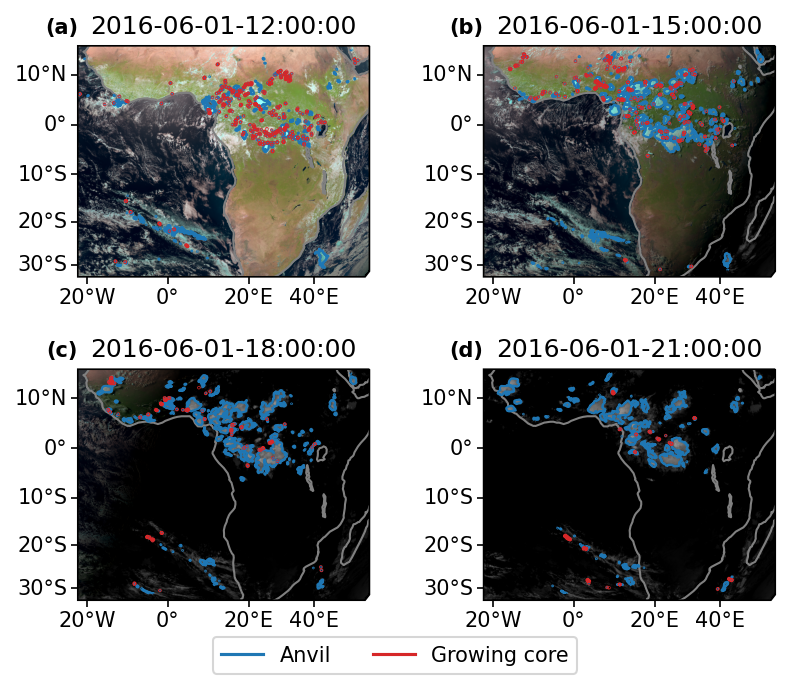

In [31]:
img_extent = (-19, 47, -33, 16)
fig = plt.figure(dpi=dpi)

cbar_size="4.5%"
cbar_pad=0.075
geo_extent = ( geo_p.x_limits[0], geo_p.x_limits[1], geo_p.y_limits[0], geo_p.y_limits[1] )

axes = []

for i in range(4):
    ds_i = 48 + (i*12)
    
    ax = plt.subplot(2, 2, i+1, projection=ccrs.Geostationary())
    
    ax.imshow(_contrast_correction(rgb_IR[i], 100)[44:3667, 51:3660], extent=geo_extent)
    ax.contour(
        dcc_ds.lon.data, dcc_ds.lat.data, dcc_ds.thick_anvil_label[ds_i], 
        levels=[0.5], colors=["C0"], linewidths=[1], transform=ccrs.PlateCarree()
    )
    ax.contour(
        dcc_ds.lon.data, dcc_ds.lat.data, np.isin(dcc_ds.core_label[ds_i], datasets[1].core), 
        levels=[0.5], colors=["C3"], linewidths=[1.5], transform=ccrs.PlateCarree()
    )
    ax.coastlines(color="grey")
    ax.set_extent(img_extent, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAKES, edgecolor='grey', alpha=1, facecolor="none")
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(), draw_labels=True,
        linewidth=1, color='gray', alpha=0.5, linestyle='--'
    )
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = False
    gl.ylines = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax_divider = make_axes_locatable(ax)
    cax_r = ax_divider.new_horizontal(size=cbar_size, pad=cbar_pad, axes_class=plt.Axes)
    ax.set_title(f"({['a','b','c','d'][i]})", loc="left", ha="right", weight="bold", fontsize=10)
    ax.set_title(pd.to_datetime(dcc_ds.t[ds_i].data).to_pydatetime().strftime('%Y-%m-%d-%H:%M:%S'))
    
    axes.append(ax)

import matplotlib.lines as mlines
fig.legend(
    [mlines.Line2D([], [], color='C0'), mlines.Line2D([], [], color='C3')], 
    ['Anvil', 'Growing core'], 
    loc='lower center', ncol=2
)

plt.subplots_adjust(hspace=0.4, wspace=0.2)
plt.draw()
for ax in axes:
    add_gl_ticks(ax, gl)

figure_list.append(plt.gcf())

## Figure 5: Map of core detections and time of day

In [32]:
core_start_lat = np.concatenate([ds.core_start_lat.data for ds in datasets])
core_start_lon = np.concatenate([ds.core_start_lon.data for ds in datasets])
core_start_t = np.concatenate([ds.core_start_t.data for ds in datasets])

# Now calculate local (solar) time using latitude
core_local_time = np.array([(pd.to_datetime(t).to_pydatetime() + timedelta(hours=core_start_lon[i]/15)).time() for i,t in enumerate(core_start_t)])

def get_fractional_hour(x):
    return x.hour + x.minute/60 + x.second/3600

core_local_hour = np.array([get_fractional_hour(t) for t in core_local_time])

In [33]:
core_is_valid = np.concatenate([ds.core_is_valid.data for ds in datasets])
print(f"Valid cores: {np.sum(core_is_valid)}; total cores: {core_is_valid.size}")

Valid cores: 145463; total cores: 146878


In [34]:
core_anvil_index = np.concatenate([ds.core_anvil_index.data for ds in datasets])
print(f"Cores with anvils: {np.sum(core_anvil_index[core_is_valid] > 0)}")

Cores with anvils: 79592


In [35]:
anvil_start_lat = np.concatenate([ds.thick_anvil_start_lat.data for ds in datasets])
anvil_start_lon = np.concatenate([ds.thick_anvil_start_lon.data for ds in datasets])
anvil_start_t = np.concatenate([ds.thick_anvil_start_t.data for ds in datasets])

# Now calculate local (solar) time using latitude
anvil_local_time = np.array([(pd.to_datetime(t).to_pydatetime() + timedelta(hours=anvil_start_lon[i]/15)).time() for i,t in enumerate(anvil_start_t)])

anvil_local_hour = np.array([get_fractional_hour(t) for t in anvil_local_time])

In [36]:
anvil_is_valid = np.concatenate([ds.thick_anvil_is_valid.data for ds in datasets])
print(f"Valid anvils: {np.sum(anvil_is_valid)}; total anvils: {anvil_is_valid.size}")

Valid anvils: 35941; total anvils: 38666


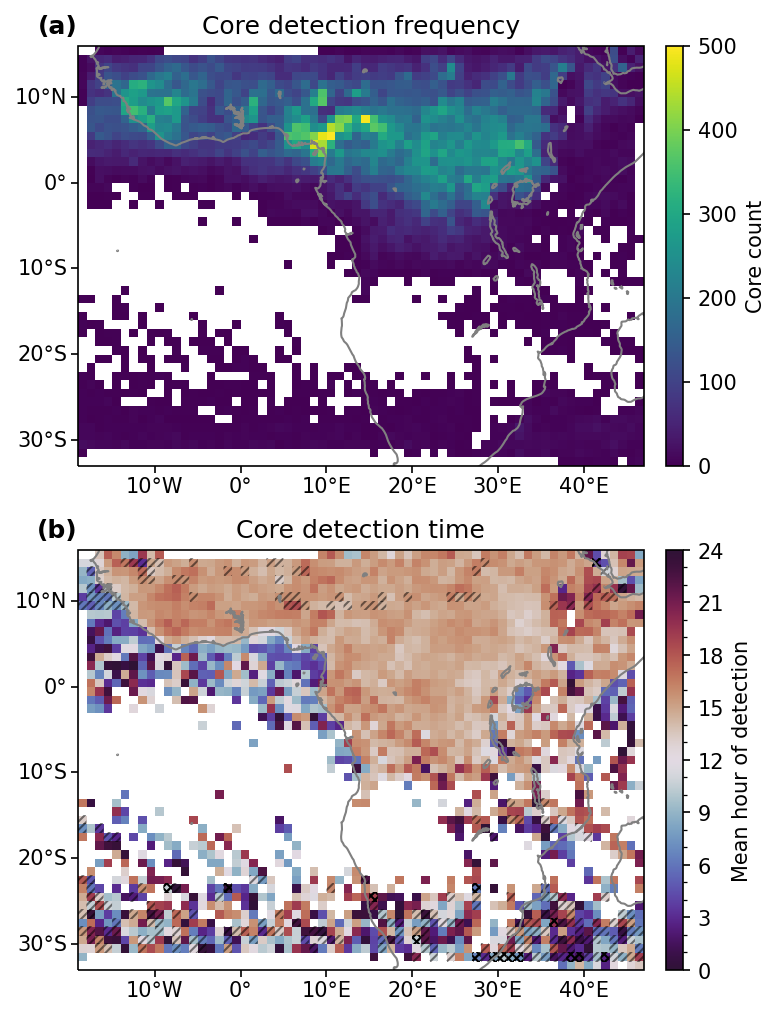

In [37]:
img_extent = (-19, 47, -33, 16)
max_count = 500
min_count = 0

fig = plt.figure(dpi=dpi, figsize=(6,8))

ax1 = plt.subplot(211, projection=ccrs.PlateCarree())
ax1.coastlines(color="grey")
ax1.add_feature(cfeature.LAKES, edgecolor='grey', alpha=1, facecolor="none")
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                   linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

h_data = np.histogram2d(
    core_start_lon, core_start_lat, 
    bins=[np.arange(img_extent[0],img_extent[1]+1), np.arange(img_extent[2],img_extent[3]+1)]
)[0]

h_img = ax1.imshow(
    ma.array(h_data, mask=h_data<=0).T[::-1],
    extent=img_extent,
    vmax=max_count, vmin=min_count
)

cbar_size="3%"
cbar_pad=0.15
ax_divider = make_axes_locatable(ax1)
cax_r = ax_divider.new_horizontal(size=cbar_size, pad=cbar_pad, axes_class=plt.Axes)
fig.add_axes(cax_r)
plt.colorbar(h_img, cax=cax_r, label="Core count")
# cax_r.yaxis.set_minor_locator(MultipleLocator(10))

ax1.set_title("(a)", loc="left", ha="right", weight="bold")
ax1.set_title("Core detection frequency", fontsize=12)

ax2 = plt.subplot(212, projection=ccrs.PlateCarree())
ax2.coastlines(color="grey")
ax2.add_feature(cfeature.LAKES, edgecolor='grey', alpha=1, facecolor="none")
gl = ax2.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False

img_data = binned_statistic_2d(
    core_start_lon, core_start_lat, core_local_hour, 
    bins=[np.arange(img_extent[0],img_extent[1]+1), 
          np.arange(img_extent[2],img_extent[3]+1)], 
    statistic=circmean_hour
)

img = ax2.imshow(
    img_data[0].T[::-1], extent=img_extent, 
    vmin=0, vmax=24, cmap="twilight_shifted"
)

hatch_data = binned_statistic_2d(
    core_start_lon, core_start_lat, core_local_hour, 
    bins=[np.arange(img_extent[0],img_extent[1]+1), 
          np.arange(img_extent[2],img_extent[3]+1)], 
    statistic=circstd_hour
)[0] * (h_data[0]/(h_data[0]-1))

for i in range(hatch_data.shape[0]):
    for j in range(hatch_data.shape[1]):
        if np.isfinite(img_data[0][i,j]):
            if np.isfinite(img_data[0][i,j]):
                if hatch_data[i,j] > 6 or np.isnan(hatch_data[i,j]):
                    ax2.add_patch(patches.Rectangle((i+img_extent[0], j+img_extent[2]), 1, 1, 
                       hatch='//////', fill=False, snap=False, linewidth=0, alpha=0.5))
                if hatch_data[i,j] > 12 or np.isnan(hatch_data[i,j]):
                    ax2.add_patch(patches.Rectangle((i+img_extent[0], j+img_extent[2]), 1, 1, 
                       hatch='//////', fill=False, snap=False, linewidth=0))
                    ax2.add_patch(patches.Rectangle((i+img_extent[0], j+img_extent[2]), 1, 1, 
                       hatch="\\\\\\\\\\\\", fill=False, snap=False, linewidth=0))

ax_divider = make_axes_locatable(ax2)
cax_r = ax_divider.new_horizontal(size=cbar_size, pad=cbar_pad, axes_class=plt.Axes)
fig.add_axes(cax_r)
cbar = plt.colorbar(img, cax=cax_r, label="Core count")
cbar.set_label("Mean hour of detection", fontsize=10)
cbar.set_ticks(range(0,25,3))
cax_r.yaxis.set_minor_locator(MultipleLocator(1))

ax2.set_title("(b)", loc="left", ha="right", weight="bold")
ax2.set_title("Core detection time", fontsize=12)

plt.draw()
add_gl_ticks(ax1, gl)
add_gl_ticks(ax2, gl)

figure_list.append(plt.gcf())

## Figure 6: Anvil properties

In [38]:
# Now set anvil_is_valid to only contain anvils north of 15S
anvil_is_valid = np.logical_and(anvil_is_valid, anvil_start_lat>-15)

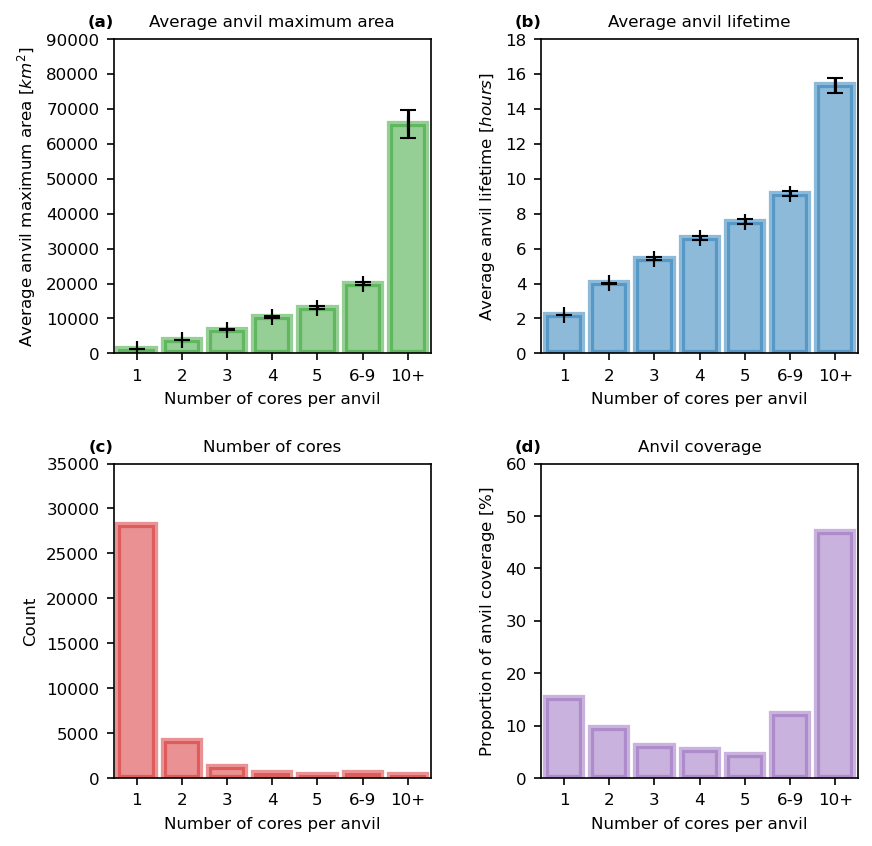

In [39]:
fig = plt.figure(dpi=dpi, figsize=(6.4,6.4))

anvil_number_of_cores = np.concatenate([ds.anvil_core_count.data for ds in datasets])
bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 9.5, 999999]
bin_positions = [1, 2, 3, 4, 5, 6, 7]
bin_labels = [1, 2, 3, 4, 5, "6-9", "10+"]

ax1 = plt.subplot(221)

anvil_max_area = np.concatenate([ds.thick_anvil_max_area.data for ds in datasets])

bar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    anvil_max_area[anvil_is_valid], 
    bins=bins, 
    statistic="mean"
)

errorbar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    anvil_max_area[anvil_is_valid], 
    bins=bins, 
    statistic="std"
)

counts = np.histogram(anvil_number_of_cores[anvil_is_valid], bins=bins)

errorbars = errorbar_data[0] / (counts[0])**0.5

plt.bar(bin_positions, bar_data[0], 
        alpha=0.5, facecolor = 'C2', edgecolor='C2', ls='solid', lw=3)
plt.errorbar(bin_positions, bar_data[0], errorbars, 0, 
             color="k", linestyle="", capsize=4)

plt.xlim([0.5,7.5])
plt.ylim([0,90000])
plt.xticks(bin_positions, bin_labels)
plt.xlabel("Number of cores per anvil", fontsize=8)
plt.ylabel("Average anvil maximum area [$km^2$]", fontsize=8)
ax1.set_title("(a)", loc="left", ha="right", weight="bold", fontsize=8)
ax1.set_title("Average anvil maximum area", fontsize=8)
ax1.tick_params(axis='both', which='major', labelsize=8)

ax2 = plt.subplot(222)

anvil_lifetime = np.concatenate([ds.thick_anvil_lifetime.data for ds in datasets]).astype("timedelta64[s]").astype(int)/3600

bar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    anvil_lifetime[anvil_is_valid], 
    bins=bins, 
    statistic="mean"
)

errorbar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    anvil_lifetime[anvil_is_valid], 
    bins=bins, 
    statistic="std"
)

counts = np.histogram(anvil_number_of_cores[anvil_is_valid], bins=bins)

errorbars = errorbar_data[0] / (counts[0])**0.5

plt.bar(bin_positions, bar_data[0], 
        alpha=0.5, facecolor = 'C0', edgecolor='C0', ls='solid', lw=3)
plt.errorbar(bin_positions, bar_data[0], errorbars, 0, 
             color="k", linestyle="", capsize=4)

plt.xlim([0.5,7.5])
plt.ylim([0,18])
plt.xticks(bin_positions, bin_labels)
plt.xlabel("Number of cores per anvil", fontsize=8)
plt.ylabel("Average anvil lifetime [$hours$]", fontsize=8)
ax2.set_title("(b)", loc="left", ha="right", weight="bold", fontsize=8)
ax2.set_title("Average anvil lifetime", fontsize=8)
ax2.tick_params(axis='both', which='major', labelsize=8)

ax3 = plt.subplot(223)

bar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    np.ones(anvil_number_of_cores.size)[anvil_is_valid], 
    bins=bins, 
    statistic="sum"
)

ax3.bar(bin_positions, bar_data[0], 
        alpha=0.5, facecolor = 'C3', edgecolor='C3', ls='solid', lw=3)

plt.xlim([0.5, 7.5])
plt.ylim([0,35000])
plt.xticks(bin_positions, bin_labels)
plt.xlabel("Number of cores per anvil", fontsize=8)
plt.ylabel("Count", fontsize=8)
ax3.set_title("(c)", loc="left", ha="right", weight="bold", fontsize=8)
ax3.set_title("Number of cores", fontsize=8)
ax3.tick_params(axis='both', which='major', labelsize=8)

ax4 = plt.subplot(224)

anvil_total_area = np.concatenate([ds.thick_anvil_total_area.data for ds in datasets])

bar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    anvil_total_area[anvil_is_valid], 
    bins=bins, 
    statistic="sum"
)

plt.bar(bin_positions, bar_data[0]/np.sum(bar_data[0])*100, 
        alpha=0.5, facecolor = 'C4', edgecolor='C4', ls='solid', lw=3)

plt.xlim([0.5,7.5])
plt.ylim([0,60])
plt.xticks(bin_positions, bin_labels)
plt.xlabel("Number of cores per anvil", fontsize=8)
plt.ylabel("Proportion of anvil coverage [$\%$]", fontsize=8)
ax4.set_title("(d)", loc="left", ha="right", weight="bold", fontsize=8)
ax4.set_title("Anvil coverage", fontsize=8)
ax4.tick_params(axis='both', which='major', labelsize=8)

plt.subplots_adjust(hspace=0.35, wspace=0.35)

figure_list.append(plt.gcf())

## Figure 7: CTT of anvils

In [40]:
def calculate_uncertainty(values, errors):
    uncertainty = (np.nansum(values**2 * errors**2))**0.5 / np.nansum(values)
    return uncertainty

In [41]:
ctt_mean = np.concatenate([ds.thick_anvil_ctt_corrected_mean.data for ds in datasets])
ctt_error = np.concatenate([ds.thick_anvil_ctt_corrected_mean_uncertainty.data for ds in datasets])


In [42]:
ctt_error

array([0.27549353, 0.10802035, 0.30958736, ..., 0.85481101, 2.94581457,
       4.01519515])

In [43]:
from tobac_flow.utils import apply_func_to_labels

labels = np.digitize(anvil_number_of_cores[anvil_is_valid], bins)

def calculate_uncertainty(values, errors):
    uncertainty = (np.nansum(values**2 * errors**2))**0.5 / np.nansum(values)
    std = np.nanstd(values) * (values.size / (values.size - 1)) / values.size**0.5
    uncertainty = (uncertainty**2 + std**2)**0.5
    return uncertainty

apply_func_to_labels(labels, ctt_mean[anvil_is_valid], ctt_error[anvil_is_valid], func=calculate_uncertainty)

array([0.07868938, 0.14261531, 0.21894326, 0.28751833, 0.32961229,
       0.25371122, 0.29982831])

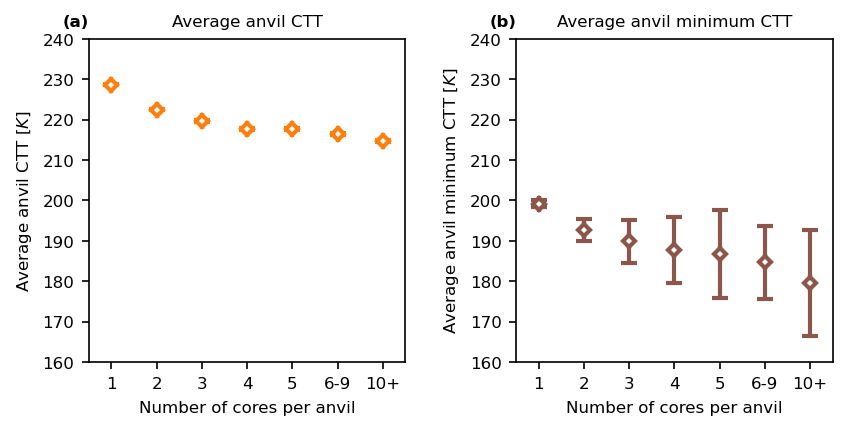

In [44]:
fig = plt.figure(dpi=dpi, figsize=(6.4,2.8))

ctt_mean = np.concatenate([ds.thick_anvil_ctt_corrected_mean.data for ds in datasets])
ctt_error = np.concatenate([ds.thick_anvil_ctt_corrected_mean_uncertainty.data for ds in datasets])

bar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    ctt_mean[anvil_is_valid], 
    bins=bins, 
    statistic="mean"
)

errorbars = apply_func_to_labels(labels, ctt_mean[anvil_is_valid], ctt_error[anvil_is_valid], func=calculate_uncertainty)

# counts = np.histogram(anvil_number_of_cores[anvil_is_valid], bins=bins)

# errorbars = errorbar_data[0] / (counts[0])**0.5

ax1 = plt.subplot(121)
# plt.bar(bin_positions, bar_data[0], 
#         alpha=0.5, facecolor = 'C1', edgecolor='C1', ls='solid', lw=3)
plt.errorbar(bin_positions, bar_data[0], errorbars, 0, 
             color="C1", fmt="D", mfc="white", ms=4, capsize=4, linewidth=2, mew=2)

plt.xlim([0.5,7.5])
plt.ylim([160,240])
plt.xticks(bin_positions, bin_labels)
plt.xlabel("Number of cores per anvil", fontsize=8)
plt.ylabel("Average anvil CTT [$K$]", fontsize=8)
ax1.set_title("(a)", loc="left", ha="right", weight="bold", fontsize=8)
ax1.set_title("Average anvil CTT", fontsize=8)
ax1.tick_params(axis='both', which='major', labelsize=8)

ctt_min = np.concatenate([ds.thick_anvil_ctt_corrected_min.data for ds in datasets])
ctt_min_error = np.concatenate([ds.thick_anvil_ctt_corrected_min_error.data for ds in datasets])

bar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    ctt_min[anvil_is_valid], 
    bins=bins, 
    statistic="mean"
)

errorbars = apply_func_to_labels(labels, ctt_min[anvil_is_valid], ctt_min_error[anvil_is_valid], func=calculate_uncertainty)


# counts = np.histogram(anvil_number_of_cores[anvil_is_valid], bins=bins)

# errorbars = errorbar_data[0] / (counts[0])**0.5

ax2 = plt.subplot(122)
# plt.bar(bin_positions, bar_data[0], 
#         alpha=0.5, facecolor = 'C5', edgecolor='C5', ls='solid', lw=3)
plt.errorbar(bin_positions, bar_data[0], errorbars, 0, 
             color="C5", fmt="D", mfc="white", ms=4, capsize=4, linewidth=2, mew=2)
             # color="k", linestyle="", capsize=4)

plt.xlim([0.5,7.5])
plt.ylim([160,240])
plt.xticks(bin_positions, bin_labels)
plt.xlabel("Number of cores per anvil", fontsize=8)
plt.ylabel("Average anvil minimum CTT [$K$]", fontsize=8)
ax2.set_title("(b)", loc="left", ha="right", weight="bold", fontsize=8)
ax2.set_title("Average anvil minimum CTT", fontsize=8)
ax2.tick_params(axis='both', which='major', labelsize=8)

plt.subplots_adjust(hspace=0.35, wspace=0.35)

figure_list.append(plt.gcf())

## Figure 8: Anvil lifetimes

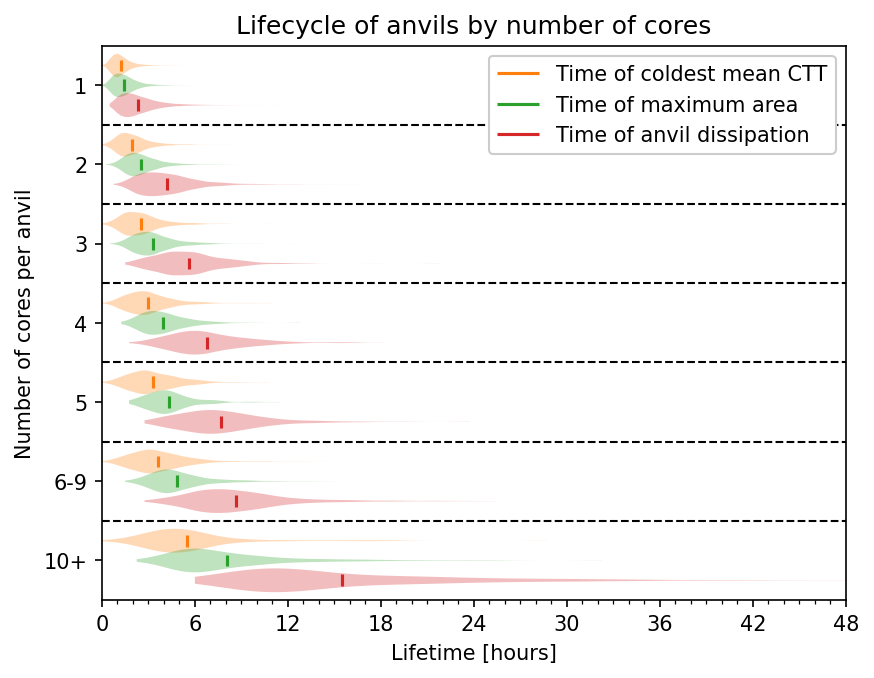

In [45]:
def anvil_initiation_t(ds):
    return np.minimum(
        ds.core_start_t.loc[ds.anvil_initial_core_index.data].data, 
        ds.thick_anvil_start_t.data
    )

anvil_time_to_min_BT = np.concatenate([ds.thick_anvil_min_ctt_t.data - anvil_initiation_t(ds) for ds in datasets]).astype("timedelta64[s]").astype(int)/3600
anvil_time_to_max_thick_area = np.concatenate([ds.thick_anvil_max_area_t.data - anvil_initiation_t(ds) for ds in datasets]).astype("timedelta64[s]").astype(int)/3600
thick_anvil_lifetime = np.concatenate([ds.thick_anvil_end_t.data - anvil_initiation_t(ds)for ds in datasets]).astype("timedelta64[s]").astype(int)/3600
thin_anvil_lifetime = np.concatenate([ds.thin_anvil_end_t.data - anvil_initiation_t(ds) for ds in datasets]).astype("timedelta64[s]").astype(int)/3600

fig = plt.figure(dpi=dpi)
ax = plt.subplot(111)

for i in range(1,8):
    if i==6:
        wh = np.logical_and(anvil_number_of_cores>=5, anvil_number_of_cores<=9)
    elif i==7:
        wh = anvil_number_of_cores>=10
    else:
        wh = anvil_number_of_cores==i
        
    wh = np.logical_and(wh, anvil_is_valid)
    
    n_points = int((np.max(anvil_time_to_min_BT[wh]) - np.min(anvil_time_to_min_BT[wh]))*4)+1
    vp2 = plt.violinplot(
        anvil_time_to_min_BT[wh], positions=[i-0.25], points=n_points, 
        widths=0.3, showextrema=False, showmeans=True, vert=False
    )
    for pc in vp2['bodies']:
        pc.set_facecolor("C1")
    vp2['cmeans'].set_edgecolor("C1")
    
    n_points = int((np.max(anvil_time_to_max_thick_area[wh]) - np.min(anvil_time_to_max_thick_area[wh]))*4)+1
    vp3 = plt.violinplot(
        anvil_time_to_max_thick_area[wh], positions=[i], points=n_points, 
        widths=0.3, showextrema=False, showmeans=True, vert=False
    )
    for pc in vp3['bodies']:
        pc.set_facecolor("C2")
    vp3['cmeans'].set_edgecolor("C2")
    
    n_points = int((np.max(thick_anvil_lifetime[wh]) - np.min(thick_anvil_lifetime[wh]))*4)+1
    vp4 = plt.violinplot(
        thick_anvil_lifetime[wh], positions=[i+0.25], points=n_points, 
        widths=0.3, showextrema=False, showmeans=True, vert=False
    )
    for pc in vp4['bodies']:
        pc.set_facecolor("C3")
    vp4['cmeans'].set_edgecolor("C3")
    
for i in range(1,7):
    ax.axhline(y=i+0.5, color='k', linestyle="--", linewidth=1)
    
plt.legend(
    [vp2['cmeans'], vp3['cmeans'], vp4['cmeans']], 
    ["Time of coldest mean CTT", "Time of maximum area", "Time of anvil dissipation"], 
    fontsize=10, framealpha=1
)

plt.gca().invert_yaxis()
plt.xlim(0,48)
plt.ylim([7.5,0.5])
plt.xticks(range(0,49,6), range(0,49,6))
ax.minorticks_on()
plt.xticks(range(0,49,1), [""]*49, minor=True)
ax.yaxis.set_tick_params(which='minor', left=False)

plt.yticks(range(1,8), [1,2,3,4,5,"6-9","10+"])#["No anvil",1,2,3,4,"5-9","10+"])

plt.xlabel("Lifetime [hours]")
plt.ylabel("Number of cores per anvil")
plt.title("Lifecycle of anvils by number of cores")

figure_list.append(plt.gcf())

## Fgiure 9: Proportion of time spent in each lifecycle stage

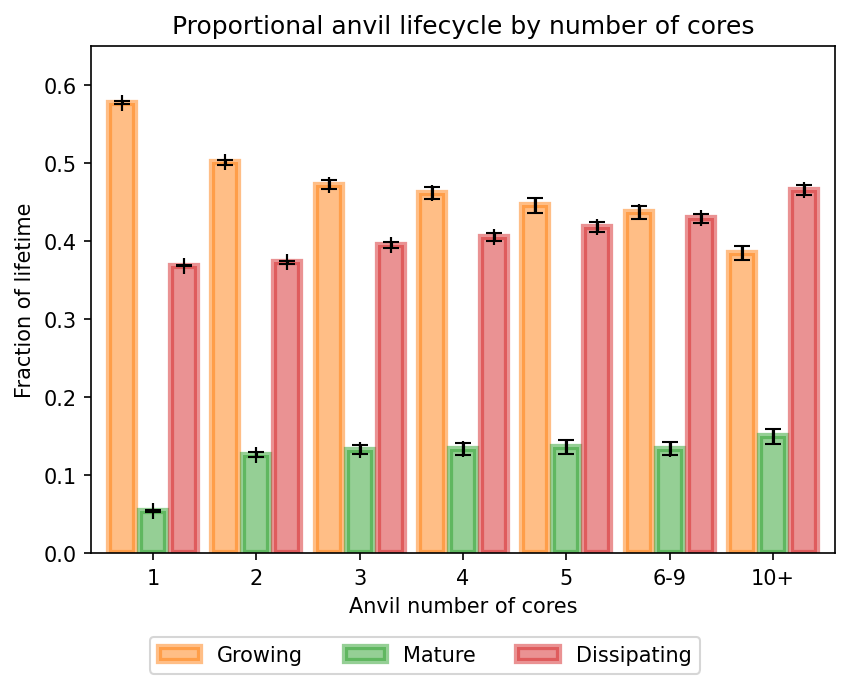

In [46]:
fig = plt.figure(dpi=dpi)

growing_time = anvil_time_to_min_BT
mature_time =  anvil_time_to_max_thick_area - anvil_time_to_min_BT
dissipating_time = thick_anvil_lifetime - anvil_time_to_max_thick_area

growing_time_prop = growing_time / thick_anvil_lifetime
mature_time_prop = mature_time / thick_anvil_lifetime
dissipating_time_prop = dissipating_time / thick_anvil_lifetime

growing_bar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    growing_time_prop[anvil_is_valid], 
    bins=bins, 
    statistic="mean"
)
growing_errorbar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    growing_time_prop[anvil_is_valid], 
    bins=bins, 
    statistic="std"
)

mature_bar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    mature_time_prop[anvil_is_valid], 
    bins=bins, 
    statistic="mean"
)
mature_errorbar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    mature_time_prop[anvil_is_valid], 
    bins=bins, 
    statistic="std"
)

dissipating_bar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    dissipating_time_prop[anvil_is_valid], 
    bins=bins, 
    statistic="mean"
)
dissipating_errorbar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    dissipating_time_prop[anvil_is_valid], 
    bins=bins, 
    statistic="std"
)

counts = np.histogram(anvil_number_of_cores[anvil_is_valid], bins=bins)

growing_errorbars = growing_errorbar_data[0] * (counts[0])**0.5 / (counts[0]-1)
mature_errorbars = mature_errorbar_data[0] * (counts[0])**0.5 / (counts[0]-1)
dissipating_errorbars = dissipating_errorbar_data[0] * (counts[0])**0.5 / (counts[0]-1)

b1 = plt.bar(
    [p-0.3 for p in bin_positions], growing_bar_data[0], width=0.25, alpha=0.5, 
    facecolor = 'C1', edgecolor='C1', ls='solid', lw=3
)
plt.errorbar(
    [p-0.3 for p in bin_positions], growing_bar_data[0], growing_errorbars, 
    0, color="k", linestyle="", capsize=4
)

b2 = plt.bar(
    bin_positions, mature_bar_data[0], width=0.25, alpha=0.5, 
    facecolor = 'C2', edgecolor='C2', ls='solid', lw=3
)
plt.errorbar(
    bin_positions, mature_bar_data[0], mature_errorbars, 
    0, color="k", linestyle="", capsize=4
)

b3 = plt.bar(
    [p+0.3 for p in bin_positions], dissipating_bar_data[0], width=0.25, alpha=0.5, 
    facecolor = 'C3', edgecolor='C3', ls='solid', lw=3
)
plt.errorbar(
    [p+0.3 for p in bin_positions], dissipating_bar_data[0], dissipating_errorbars, 
    0, color="k", linestyle="", capsize=4
)

plt.xlim([0.4,7.6])
plt.ylim([0,0.65])
plt.xticks(bin_positions, bin_labels)
plt.ylabel("Fraction of lifetime")
plt.xlabel("Anvil number of cores")
plt.title("Proportional anvil lifecycle by number of cores")

plt.subplots_adjust(bottom=0.175)

fig.legend(
    [b1, b2, b3], 
    ["Growing", "Mature", "Dissipating"], 
    loc="lower center", ncols=3, borderaxespad=0.5
)

figure_list.append(plt.gcf())

## Figure 10: Examples of isolated, complex and MCS DCCs

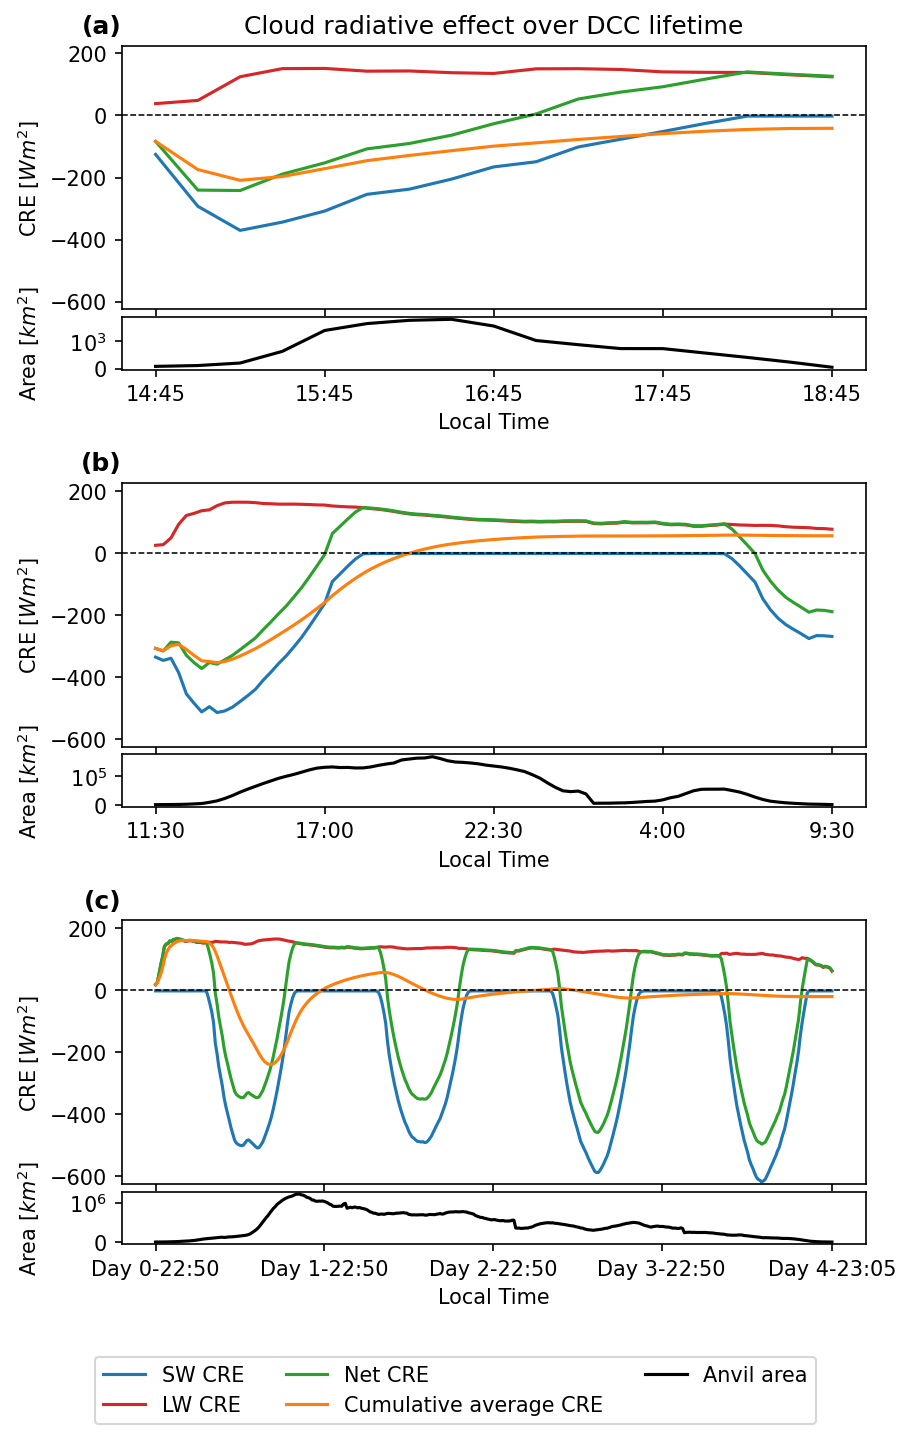

In [47]:
fig = plt.figure(dpi=dpi, figsize=(6.4,10.8))

#==============
# Isolated case
#==============
ax1 = plt.subplot(311)

dataset = datasets[2]
anvil = 18102
wh_thick_anvil_step = dataset.thick_anvil_step_anvil_index.data==anvil
wh_thin_anvil_step = dataset.thin_anvil_step_anvil_index.data==anvil


ax1.plot(-dataset.thick_anvil_step_toa_swup_cre_mean[dataset.thick_anvil_step_anvil_index==anvil]-sw_bias, "C0")
ax1.plot(-dataset.thick_anvil_step_toa_lwup_cre_mean[dataset.thick_anvil_step_anvil_index==anvil]-lw_bias, "C3")
ax1.plot(dataset.thick_anvil_step_toa_net_cre_mean[dataset.thick_anvil_step_anvil_index==anvil]+net_bias, "C2")

cumulative_forcing = np.cumsum((dataset.thick_anvil_step_toa_net_cre_mean[dataset.thick_anvil_step_anvil_index==anvil]+net_bias) * dataset.thick_anvil_step_area[dataset.thick_anvil_step_anvil_index==anvil])
cumulative_forcing /= np.cumsum(dataset.thick_anvil_step_area[dataset.thick_anvil_step_anvil_index==anvil])
ax1.plot(cumulative_forcing, "C1")

# Add area
ax_divider = make_axes_locatable(ax1)
ax1l = ax_divider.append_axes("bottom", size="20%", pad=0.05, axes_class=plt.Axes)
fig.add_axes(ax1l)
ax1l.plot(dataset.thick_anvil_step_area[dataset.thick_anvil_step_anvil_index==anvil], "k")

anvil_dt = dataset.thick_anvil_step_t[dataset.thick_anvil_step_anvil_index==anvil].to_series().dt.to_pydatetime()
anvil_local_time = anvil_dt + timedelta(hours=dataset.thick_anvil_start_lon.loc[anvil].item()/15)
anvil_time_str = [f"{dt.hour}:{dt.minute//5*5:02d}" for dt in anvil_local_time]

n_time_steps = len(anvil_time_str)
xtick_locs = np.linspace(0, n_time_steps-1, 5).astype(int)

ax1.set_xticks(xtick_locs, [""]*5)
ax1l.set_xticks(xtick_locs, np.asarray(anvil_time_str)[xtick_locs])
ax1l.set_xlabel("Local Time")

ax1.set_ylabel("CRE [$Wm^2$]")
ax1.set_ylim([-625,225])

ax1l.set_ylabel("Area [$km^2$]")
ax1l.set_yticks([0,1e3],["0","   $10^3$"])

ax1.axhline(y=0, color='k', linestyle="--", linewidth=0.75)

ax1.set_title("(a)", loc="left", ha="right", weight="bold")
ax1.set_title('Cloud radiative effect over DCC lifetime')


#===============
# Clustered case
#===============
ax2 = plt.subplot(312)

dataset = datasets[2]
anvil = 7946
wh_thick_anvil_step = dataset.thick_anvil_step_anvil_index.data==anvil
wh_thin_anvil_step = dataset.thin_anvil_step_anvil_index.data==anvil


ax2.plot(-dataset.thick_anvil_step_toa_swup_cre_mean[dataset.thick_anvil_step_anvil_index==anvil]-sw_bias, "C0")
ax2.plot(-dataset.thick_anvil_step_toa_lwup_cre_mean[dataset.thick_anvil_step_anvil_index==anvil]-lw_bias, "C3")
ax2.plot(dataset.thick_anvil_step_toa_net_cre_mean[dataset.thick_anvil_step_anvil_index==anvil]+net_bias, "C2")

cumulative_forcing = np.cumsum((dataset.thick_anvil_step_toa_net_cre_mean[dataset.thick_anvil_step_anvil_index==anvil]+net_bias) * dataset.thick_anvil_step_area[dataset.thick_anvil_step_anvil_index==anvil])
cumulative_forcing /= np.cumsum(dataset.thick_anvil_step_area[dataset.thick_anvil_step_anvil_index==anvil])
ax2.plot(cumulative_forcing, "C1")

# Add area
ax_divider = make_axes_locatable(ax2)
ax2l = ax_divider.append_axes("bottom", size="20%", pad=0.05, axes_class=plt.Axes)
fig.add_axes(ax2l)
ax2l.plot(dataset.thick_anvil_step_area[dataset.thick_anvil_step_anvil_index==anvil], "k")

anvil_dt = dataset.thick_anvil_step_t[dataset.thick_anvil_step_anvil_index==anvil].to_series().dt.to_pydatetime()
anvil_local_time = anvil_dt + timedelta(hours=dataset.thick_anvil_start_lon.loc[anvil].item()/15)
anvil_time_str = [f"{dt.hour}:{dt.minute//5*5:02d}" for dt in anvil_local_time]

n_time_steps = len(anvil_time_str)
xtick_locs = np.linspace(0, n_time_steps-1, 5).astype(int)

ax2.set_xticks(xtick_locs, [""]*5)
ax2l.set_xticks(xtick_locs, np.asarray(anvil_time_str)[xtick_locs])
ax2l.set_xlabel("Local Time")

ax2.set_ylabel("CRE [$Wm^2$]")
ax2.set_ylim([-625,225])

ax2l.set_ylabel("Area [$km^2$]")
ax2l.set_yticks([0,1e5],["0","   $10^5$"])

ax2.axhline(y=0, color='k', linestyle="--", linewidth=0.75)

ax2.set_title("(b)", loc="left", ha="right", weight="bold")

#===============
# MCS case
#===============
ax3 = plt.subplot(313)

dataset = datasets[2]
anvil = 16125
wh_thick_anvil_step = dataset.thick_anvil_step_anvil_index.data==anvil
wh_thin_anvil_step = dataset.thin_anvil_step_anvil_index.data==anvil

ax3.plot(-dataset.thick_anvil_step_toa_swup_cre_mean[dataset.thick_anvil_step_anvil_index==anvil]-sw_bias, "C0")
ax3.plot(-dataset.thick_anvil_step_toa_lwup_cre_mean[dataset.thick_anvil_step_anvil_index==anvil]-lw_bias, "C3")
ax3.plot(dataset.thick_anvil_step_toa_net_cre_mean[dataset.thick_anvil_step_anvil_index==anvil]+net_bias, "C2")

cumulative_forcing = np.cumsum((dataset.thick_anvil_step_toa_net_cre_mean[dataset.thick_anvil_step_anvil_index==anvil]+net_bias) * dataset.thick_anvil_step_area[dataset.thick_anvil_step_anvil_index==anvil])
cumulative_forcing /= np.cumsum(dataset.thick_anvil_step_area[dataset.thick_anvil_step_anvil_index==anvil])
ax3.plot(cumulative_forcing, "C1")

# Add area
ax_divider = make_axes_locatable(ax3)
ax3l = ax_divider.append_axes("bottom", size="20%", pad=0.05, axes_class=plt.Axes)
fig.add_axes(ax3l)
ax3l.plot(dataset.thick_anvil_step_area[dataset.thick_anvil_step_anvil_index==anvil], "k")

anvil_dt = dataset.thick_anvil_step_t[dataset.thick_anvil_step_anvil_index==anvil].to_series().dt.to_pydatetime()
anvil_local_time = anvil_dt + timedelta(hours=dataset.thick_anvil_start_lon.loc[anvil].item()/15)
anvil_time_str = [f"Day {i//96}-{dt.hour}:{dt.minute//5*5:02d}" for i, dt in enumerate(anvil_local_time)]

n_time_steps = len(anvil_time_str)
xtick_locs = np.linspace(0, n_time_steps-1, 5).astype(int)

ax3.set_xticks(xtick_locs, [""]*5)
ax3l.set_xticks(xtick_locs, np.asarray(anvil_time_str)[xtick_locs])
ax3l.set_xlabel("Local Time")

ax3.set_ylabel("CRE [$Wm^2$]")
ax3.set_ylim([-625,225])

ax3l.set_ylabel("Area [$km^2$]")
ax3l.set_yticks([0,1e6],["0","   $10^6$"])

ax3.axhline(y=0, color='k', linestyle="--", linewidth=0.75)

ax3.set_title("(c)", loc="left", ha="right", weight="bold")

plt.subplots_adjust(hspace=0.35, bottom=0.14)
import matplotlib.lines as mlines
fig.legend(
    [
        mlines.Line2D([], [], color='C0'), 
        mlines.Line2D([], [], color='C3'), 
        mlines.Line2D([], [], color='C2'), 
        mlines.Line2D([], [], color='C1'),
        mlines.Line2D([], [], color='k'),
    ], 
    ["SW CRE", "LW CRE", "Net CRE", "Cumulative average CRE", "Anvil area"], 
    loc="lower center", ncols=3, borderaxespad=1.5
)

figure_list.append(plt.gcf())

## Figure 11: Distribution of anvil CRE

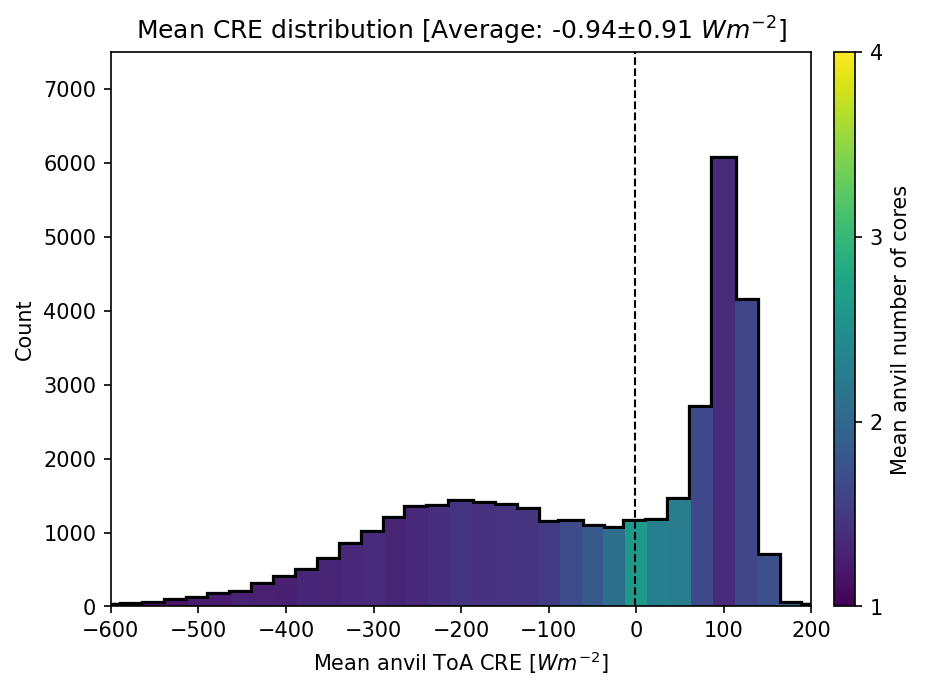

In [48]:
net_cre = np.concatenate([ds.thick_anvil_toa_net_cre_mean.data+net_bias for ds in datasets])

fig = plt.figure(dpi=dpi)
ax = plt.subplot(111)

plt.hist(
    net_cre[anvil_is_valid], bins=np.arange(-600,226,25)-12.5,  
    alpha=1, facecolor = 'none', edgecolor='black', ls='solid', lw=3, histtype='stepfilled'
)

bar_data = np.histogram(net_cre[anvil_is_valid], bins=np.arange(-600,226,25)-12.5)[0]
bar_color = binned_statistic(
    net_cre[anvil_is_valid], 
    anvil_number_of_cores[anvil_is_valid], 
    bins=np.arange(-600,226,25)-12.5, 
    statistic="mean"
)[0]

bar = plt.bar(
    np.arange(-600,225,25), bar_data, width=25,  
    alpha=1, color=plt.cm.viridis((bar_color-1)/3), edgecolor='none'
)

plt.xlim([-600,200])
plt.xlabel("Mean anvil ToA CRE [$Wm^{-2}$]", fontsize=10)
plt.ylabel("Count", fontsize=10)
plt.ylim([0,7500])


cbar_size="3%"
cbar_pad=0.15

img = plt.imshow(np.array([[1,4]]), aspect="auto")
img.set_visible(False)
ax_divider = make_axes_locatable(ax)
cax_r = ax_divider.new_horizontal(size=cbar_size, pad=cbar_pad, axes_class=plt.Axes)
fig.add_axes(cax_r)
cbar = plt.colorbar(img, cax=cax_r, label="Mean anvil number of cores")
cbar.set_ticks([1,2,3,4])

mean_cre = np.average(net_cre[anvil_is_valid], weights=anvil_total_area[anvil_is_valid])
mean_error = np.std(net_cre[anvil_is_valid])*np.sum(anvil_is_valid)**0.5/(np.sum(anvil_is_valid)-1)
ax.axvline(x=mean_cre, color='k', linestyle="--", linewidth=1)

# ax.set_title("(a)", loc="left", ha="right", weight="bold")
ax.set_title("Mean CRE distribution [Average: %0.2f±%0.2f $Wm^{-2}$]" % ((np.round(mean_cre, 2)), (np.round(mean_error, 2))))

figure_list.append(plt.gcf())

## Figure 12: Distribution of SW and LW anvil CRE

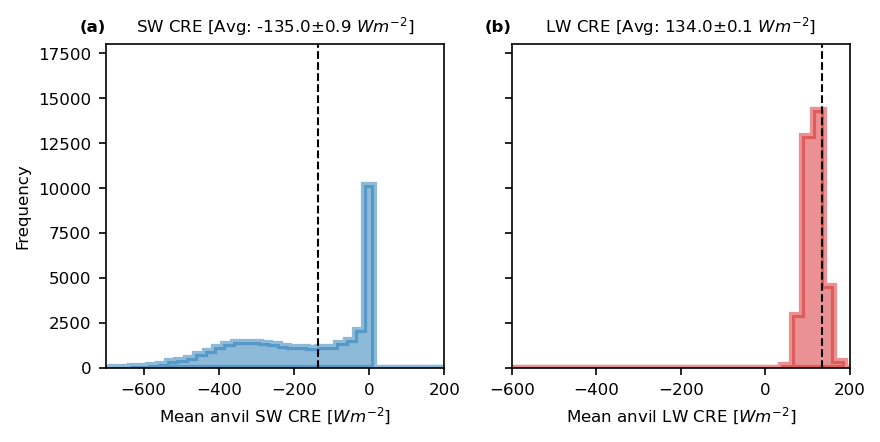

In [49]:
sw_cre = np.concatenate([-ds.thick_anvil_toa_swup_cre_mean.data+sw_bias for ds in datasets])

plt.figure(dpi=dpi, figsize=(6.4,2.8))
ax = plt.subplot(121)
plt.hist(sw_cre[anvil_is_valid], bins=np.arange(-700,226,25)-12.5,  
         alpha=0.5, facecolor = 'C0', edgecolor='C0', ls='solid', lw=3, histtype='stepfilled')
plt.xlim([-700,200])
plt.xlabel("Mean anvil SW CRE [$Wm^{-2}$]", fontsize=8)
plt.ylabel("Frequency", fontsize=8)
plt.yticks(range(0,18000,2500))
ax.tick_params(axis='both', which='major', labelsize=8)
plt.ylim([0,18000])
mean_cre = np.average(sw_cre[anvil_is_valid], weights=anvil_total_area[anvil_is_valid])
mean_error = np.std(sw_cre[anvil_is_valid])*np.sum(anvil_is_valid)**0.5/(np.sum(anvil_is_valid)-1)
ax.set_title("SW CRE [Avg: %s±%s $Wm^{-2}$]" % (str(np.round(mean_cre, 1)), str(np.round(mean_error, 1))), fontsize=8)
ax.set_title("(a)", loc="left", ha="right", weight="bold", fontsize=8)

ax.axvline(x=mean_cre, color='k', linestyle="--", linewidth=1)

lw_cre = np.concatenate([-ds.thick_anvil_toa_lwup_cre_mean.data+lw_bias for ds in datasets])

ax = plt.subplot(122)
plt.hist(lw_cre[anvil_is_valid], bins=np.arange(-600,226,25)-12.5,  
         alpha=0.5, facecolor = 'C3', edgecolor='C3', ls='solid', lw=3, histtype='stepfilled')
plt.xlim([-600,200])
plt.xlabel("Mean anvil LW CRE [$Wm^{-2}$]", fontsize=8)
# plt.ylabel("Frequency", fontsize=12)
plt.yticks(range(0,18000,2500), [""]*8)
ax.tick_params(axis='both', which='major', labelsize=8)
plt.ylim([0,18000])
mean_cre = np.average(lw_cre[anvil_is_valid], weights=anvil_total_area[anvil_is_valid])
mean_error = np.std(lw_cre[anvil_is_valid])*np.sum(anvil_is_valid)**0.5/(np.sum(anvil_is_valid)-1)
ax.set_title("LW CRE [Avg: %s±%s $Wm^{-2}$]" % (str(np.round(mean_cre, 1)), str(np.round(mean_error, 1))), fontsize=8)
ax.set_title("(b)", loc="left", ha="right", weight="bold", fontsize=8)

ax.axvline(x=mean_cre, color='k', linestyle="--", linewidth=1)

figure_list.append(plt.gcf())

## Figure 13: Average anvil CRE by average CTT and time of initiation

In [50]:
ctt_mean = np.concatenate([ds.thick_anvil_ctt_corrected_mean.data for ds in datasets])
step_net_cre = np.concatenate([ds.thick_anvil_step_toa_net_cre_mean.data+net_bias for ds in datasets])
step_ctt_mean = np.concatenate([ds.thick_anvil_step_ctt_corrected_mean.data for ds in datasets])

anvil_step_is_valid = np.concatenate([ds.thick_anvil_is_valid.loc[ds.thick_anvil_step_anvil_index].data for ds in datasets])

anvil_step_t = np.concatenate([ds.thick_anvil_step_t.data for ds in datasets])
anvil_step_lon = np.concatenate([ds.thick_anvil_step_lon.data for ds in datasets])

step_local_time = np.array([(pd.to_datetime(t).to_pydatetime() + timedelta(hours=anvil_step_lon[i]/15)).time() for i,t in enumerate(anvil_step_t)])
step_local_hour = np.array([get_fractional_hour(t) for t in step_local_time])


In [51]:
time_bins = np.arange(0,25,1)
ctt_bins = np.arange(200,251,2.5)
ctt_bins[0] = 100
ctt_bins[-1] = 300

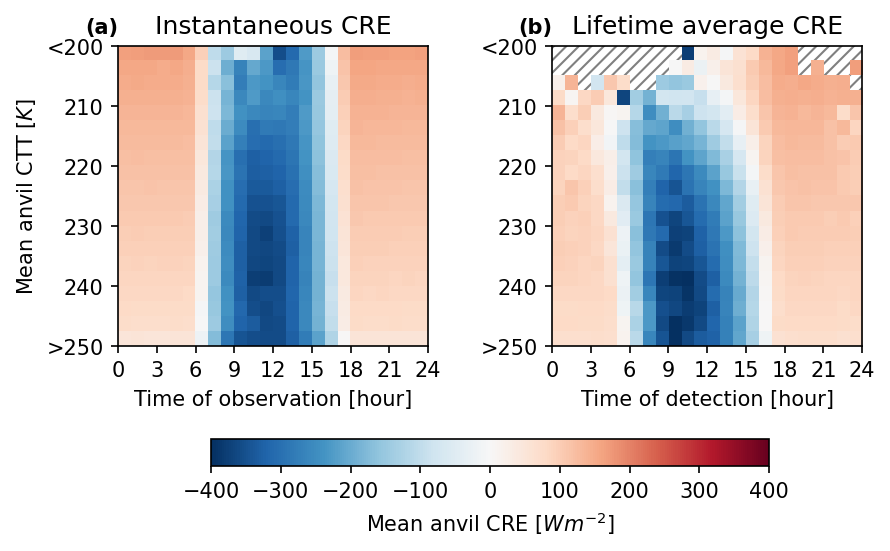

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, dpi=dpi, figsize=(6.4,4))

img_data = binned_statistic_2d(
    step_ctt_mean[anvil_step_is_valid], 
    step_local_hour[anvil_step_is_valid], 
    step_net_cre[anvil_step_is_valid], 
    bins=[ctt_bins, time_bins]
)[0]

ax1.patch.set_hatch("////")
ax1.patch.set_edgecolor("grey")
im1 = ax1.imshow(img_data, cmap="RdBu_r", vmin=-400, vmax=400, aspect="auto")
# cbar = plt.colorbar(im1, ax=ax1)
# cbar.set_label("Mean anvil CRE [$Wm^{-2}$]", fontsize=12)

ax1.set_xticks((np.arange(len(time_bins))-0.5)[::3], time_bins[::3])
ax1.set_xlabel("Time of observation [hour]", fontsize=10)
ax1.set_yticks(np.arange(len(ctt_bins))[::4]-0.5, ["<200"]+list(range(210,250,10))+[">250"])
ax1.set_ylabel("Mean anvil CTT [$K$]", fontsize=10)

ax1.set_title("(a)", loc="left", ha="right", weight="bold", fontsize=10)
ax1.set_title("Instantaneous CRE", fontsize=12)



img_data = binned_statistic_2d(
    ctt_mean[anvil_is_valid], 
    anvil_local_hour[anvil_is_valid], 
    net_cre[anvil_is_valid], 
    bins=[ctt_bins, time_bins]
)[0]

ax2.patch.set_hatch("////")
ax2.patch.set_edgecolor("grey")
im2 = ax2.imshow(img_data, cmap="RdBu_r", vmin=-400, vmax=400, aspect="auto")

ax2.set_xticks((np.arange(len(time_bins))-0.5)[::3], time_bins[::3])
ax2.set_xlabel("Time of detection [hour]", fontsize=10)
ax2.set_yticks(np.arange(len(ctt_bins))[::4]-0.5, ["<200"]+list(range(210,250,10))+[">250"])
# ax2.set_ylabel("Mean anvil CTT [$K$]", fontsize=10)

ax2.set_title("(b)", loc="left", ha="right", weight="bold", fontsize=10)
ax2.set_title("Lifetime average CRE", fontsize=12)

plt.subplots_adjust(wspace=0.4)

cbar = fig.colorbar(im2, ax=[ax1,ax2], orientation="horizontal", pad=0.2, shrink=0.75)
cbar.set_label("Mean anvil CRE [$Wm^{-2}$]", fontsize=10)

figure_list.append(plt.gcf())

## Supplementary figure 4: Contribution to total anvil CRE by number of cores

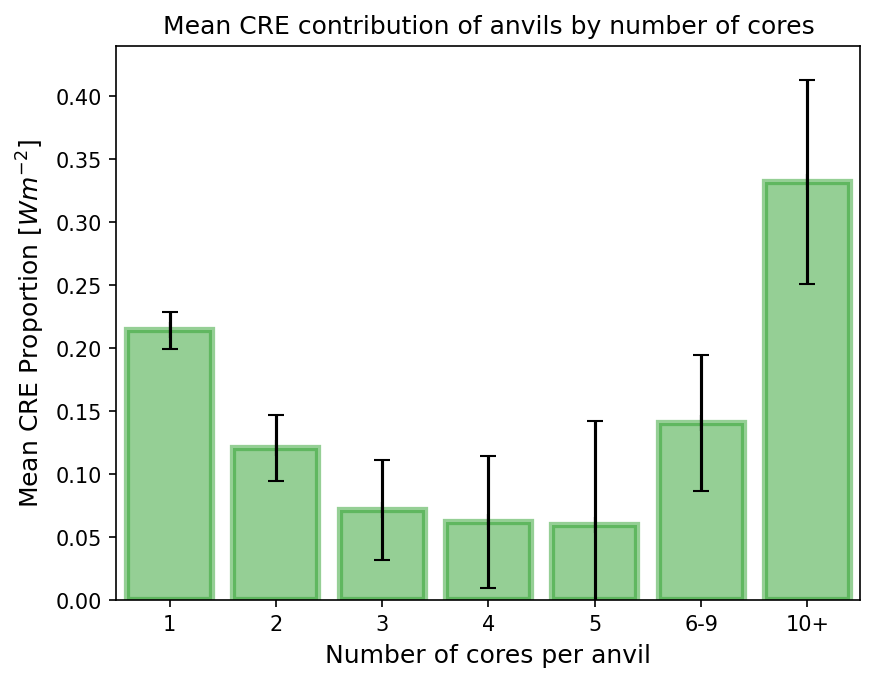

In [53]:
bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 9.5, 999999]
bin_positions = [1, 2, 3, 4, 5, 6, 7]
bin_labels = [1, 2, 3, 4, 5, "6-9", "10+"]

bar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    np.abs(net_cre[anvil_is_valid])*anvil_total_area[anvil_is_valid], 
    bins=bins, 
    statistic="sum"
)[0]

total_bar = bar_data.sum()

bar_data /= total_bar

errorbar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    (np.abs(net_cre[anvil_is_valid])*anvil_total_area[anvil_is_valid]), 
    bins=bins, 
    statistic="std"
)[0] / binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    (np.abs(net_cre[anvil_is_valid])*anvil_total_area[anvil_is_valid]), 
    bins=bins, 
    statistic="mean"
)[0]

counts = np.histogram(anvil_number_of_cores[anvil_is_valid], bins=bins)

errorbars = errorbar_data * (counts[0]/(counts[0]-1)) / (counts[0])**0.5

plt.figure(dpi=dpi)
plt.bar(bin_positions, bar_data, 
        alpha=0.5, facecolor = 'C2', edgecolor='C2', ls='solid', lw=3)
plt.errorbar(bin_positions, bar_data, errorbars, 0, 
             color="k", linestyle="", capsize=4)

plt.xlim([0.5, 7.5])
plt.ylim([0,0.44])
plt.xticks(bin_positions, bin_labels)
plt.xlabel("Number of cores per anvil",fontsize=12)
plt.ylabel("Mean CRE Proportion [$Wm^{-2}$]",fontsize=12)
plt.title("Mean CRE contribution of anvils by number of cores",fontsize=12)

figure_list.append(plt.gcf())

In [54]:
for i, fig in enumerate(figure_list):
    fig.savefig(
        save_path / f'chapter4_{(i+1):02d}.{format}',
        bbox_inches="tight", pad_inches=0.25
    )

/Users/jonesw/mambaforge-pypy3/envs/thesis_notebooks/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
